# Credit card customer segmentation

## Importing libraries and setup

In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# ----------------------------------GENERAL---------------------------------

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------VISUALIZATION---------------------------

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.manifold import TSNE  
from umap import UMAP
from plotly import graph_objs as go
from yellowbrick.cluster import KElbowVisualizer
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 8)

# ----------------------------------PRE-PROCESSING---------------------------

from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize, OneHotEncoder, PowerTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import silhouette_samples, silhouette_score

# ----------------------------------PIPELINE AND MODELS----------------------

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Data loading and cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data loading

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML_day_9_10/data/card_transactions.csv")

In [ ]:
# data shape

df.shape

(8500, 18)

### DataFrame overview

In [ ]:
# data quick overview

df.head()

customer_id  balance_account  purchases_amount  paid_advance  \
0  tGEg8fT2eCgVxdwS         9.298409            107.60      0.000000   
1  stEDu20sSKOXomjg        52.666422            150.30      0.000000   
2  CEB2blrN3b88GsRe      1360.795674              0.00    462.861443   
3  0N0eBl8ySaZThxKE      2021.641161            363.18      0.000000   
4  6NLauoHUwtwOv4Wy        22.322374             95.00   1162.045833   

   full_purchases  balance_frequency_update  installments  \
0            0.00                  0.909091         107.6   
1            0.00                  1.000000         150.3   
2            0.00                  1.000000           0.0   
3          363.18                  1.000000           0.0   
4           95.00                  0.363636           0.0   

   purchases_frequency  full_purchases_frequency  \
0             0.909091                  0.000000   
1             1.000000                  0.000000   
2             0.000000                  0.000000   
3             1.000000                  1.000000   
4             0.083333                  0.083333   

   purchases_installments_frequency  cash_advance_frequency  nr_cash_advances  \
0                          0.818182                0.000000                 0   
1                          0.833333                0.000000                 0   
2                          0.000000                0.272727                 6   
3                          0.000000                0.000000                 0   
4                          0.000000                0.166667                 3   

   nr_purchases  credit_limit  fixed_rate_period     payments  min_payments  \
0            10        1000.0                 11    89.868853     89.711672   
1             6        1000.0                  6    54.722514     82.955180   
2             0        1500.0                 11   303.031979    443.781316   
3            13        2000.0                 12   704.240770    795.859808   
4             1        2500.0                 12  4094.261427     40.142262   

   full_payment_prc  
0          0.428571  
1          0.000000  
2          0.000000  
3          0.000000  
4          0.000000

In [ ]:
# data columns check

df.columns

Index(['customer_id', 'balance_account', 'purchases_amount', 'paid_advance',
       'full_purchases', 'balance_frequency_update', 'installments',
       'purchases_frequency', 'full_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'nr_cash_advances', 'nr_purchases', 'credit_limit', 'fixed_rate_period',
       'payments', 'min_payments', 'full_payment_prc'],
      dtype='object')

In [ ]:
# df info

df.info()

# missing values on credit_limit and min_payments

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       8500 non-null   object 
 1   balance_account                   8500 non-null   float64
 2   purchases_amount                  8500 non-null   float64
 3   paid_advance                      8500 non-null   float64
 4   full_purchases                    8500 non-null   float64
 5   balance_frequency_update          8500 non-null   float64
 6   installments                      8500 non-null   float64
 7   purchases_frequency               8500 non-null   float64
 8   full_purchases_frequency          8500 non-null   float64
 9   purchases_installments_frequency  8500 non-null   float64
 10  cash_advance_frequency            8500 non-null   float64
 11  nr_cash_advances                  8500 non-null   int64  
 12  nr_pur

In [ ]:
# summary statistics for numerical variables

df.describe()

balance_account  purchases_amount  paid_advance  full_purchases  \
count      8500.000000       8500.000000   8500.000000     8500.000000   
mean       1565.941403        999.561312    973.508540      588.165365   
std        2090.513302       2154.189460   2078.539061     1669.466184   
min           0.000000          0.000000      0.000000        0.000000   
25%         126.318369         39.000000      0.000000        0.000000   
50%         869.046468        360.000000      0.000000       37.400000   
75%        2053.674410       1105.897500   1113.726110      570.410000   
max       19043.138560      49039.570000  47137.211760    40761.250000   

       balance_frequency_update  installments  purchases_frequency  \
count               8500.000000   8500.000000          8500.000000   
mean                   0.876272    411.708492             0.489383   
std                    0.237517    910.142440             0.401075   
min                    0.000000      0.000000             0.000000   
25%                    0.875000      0.000000             0.083333   
50%                    1.000000     89.000000             0.500000   
75%                    1.000000    466.725000             0.916667   
max                    1.000000  22500.000000             1.000000   

       full_purchases_frequency  purchases_installments_frequency  \
count               8500.000000                       8500.000000   
mean                   0.201940                          0.363796   
std                    0.297756                          0.397162   
min                    0.000000                          0.000000   
25%                    0.000000                          0.000000   
50%                    0.083333                          0.166667   
75%                    0.285714                          0.750000   
max                    1.000000                          1.000000   

       cash_advance_frequency  nr_cash_advances  nr_purchases  credit_limit  \
count             8500.000000       8500.000000   8500.000000   8499.000000   
mean                 0.135288          3.253647     14.677059   4485.848704   
std                  0.200892          6.854883     25.001561   3629.804040   
min                  0.000000          0.000000      0.000000     50.000000   
25%                  0.000000          0.000000      1.000000   1500.000000   
50%                  0.000000          0.000000      7.000000   3000.000000   
75%                  0.222222          4.000000     17.000000   6500.000000   
max                  1.500000        123.000000    358.000000  30000.000000   

       fixed_rate_period      payments  min_payments  full_payment_prc  
count        8500.000000   8500.000000   8202.000000       8500.000000  
mean           11.516118   1721.250989    865.594683          0.152587  
std             1.339121   2893.200899   2389.297977          0.291505  
min             6.000000      0.000000      0.019163          0.000000  
25%            12.000000    381.893717    168.712104          0.000000  
50%            12.000000    851.146952    310.399040          0.000000  
75%            12.000000   1897.014052    826.426929          0.142857  
max            12.000000  50721.483360  76406.207520          1.000000

### Addressing customer_id

In [ ]:
# customer_id => all unique values with no meaning => drop

df.describe(exclude=[np.number])

customer_id
count               8500
unique              8500
top     tGEg8fT2eCgVxdwS
freq                   1

In [ ]:
# dropping customer_id

df.drop(['customer_id'], axis=1, inplace=True)

### Solve null values

In [ ]:
# identifying null values

df.isnull().sum()

balance_account                       0
purchases_amount                      0
paid_advance                          0
full_purchases                        0
balance_frequency_update              0
installments                          0
purchases_frequency                   0
full_purchases_frequency              0
purchases_installments_frequency      0
cash_advance_frequency                0
nr_cash_advances                      0
nr_purchases                          0
credit_limit                          1
fixed_rate_period                     0
payments                              0
min_payments                        298
full_payment_prc                      0
dtype: int64

#### Drop credit_limit

In [ ]:
# credit_limit

df.dropna(subset=['credit_limit'], inplace=True)

# replace by mean?
# ccc['credit_limit'].fillna(ccc['credit limit'].mean(), inplace=True)

#### KNNImputer min_payments

In [ ]:
# numeric transformer
# KNNImputer to fill missing values

df_pre_knn = df.copy(deep=True)

In [ ]:
imputer = KNNImputer(n_neighbors=5)
df_knn = imputer.fit_transform(df_pre_knn)

In [ ]:
df_knn = pd.DataFrame(data=df_knn, columns=df_pre_knn.columns)
df_knn.head()

balance_account  purchases_amount  paid_advance  full_purchases  \
0         9.298409            107.60      0.000000            0.00   
1        52.666422            150.30      0.000000            0.00   
2      1360.795674              0.00    462.861443            0.00   
3      2021.641161            363.18      0.000000          363.18   
4        22.322374             95.00   1162.045833           95.00   

   balance_frequency_update  installments  purchases_frequency  \
0                  0.909091         107.6             0.909091   
1                  1.000000         150.3             1.000000   
2                  1.000000           0.0             0.000000   
3                  1.000000           0.0             1.000000   
4                  0.363636           0.0             0.083333   

   full_purchases_frequency  purchases_installments_frequency  \
0                  0.000000                          0.818182   
1                  0.000000                          0.833333   
2                  0.000000                          0.000000   
3                  1.000000                          0.000000   
4                  0.083333                          0.000000   

   cash_advance_frequency  nr_cash_advances  nr_purchases  credit_limit  \
0                0.000000               0.0          10.0        1000.0   
1                0.000000               0.0           6.0        1000.0   
2                0.272727               6.0           0.0        1500.0   
3                0.000000               0.0          13.0        2000.0   
4                0.166667               3.0           1.0        2500.0   

   fixed_rate_period     payments  min_payments  full_payment_prc  
0               11.0    89.868853     89.711672          0.428571  
1                6.0    54.722514     82.955180          0.000000  
2               11.0   303.031979    443.781316          0.000000  
3               12.0   704.240770    795.859808          0.000000  
4               12.0  4094.261427     40.142262          0.000000

#### No null values check

In [ ]:
df_knn.isnull().sum()

balance_account                     0
purchases_amount                    0
paid_advance                        0
full_purchases                      0
balance_frequency_update            0
installments                        0
purchases_frequency                 0
full_purchases_frequency            0
purchases_installments_frequency    0
cash_advance_frequency              0
nr_cash_advances                    0
nr_purchases                        0
credit_limit                        0
fixed_rate_period                   0
payments                            0
min_payments                        0
full_payment_prc                    0
dtype: int64

In [ ]:
df_clean = df_knn.copy(deep=True)

## Data visualization (cleaned)

In [ ]:
# df => raw
# df_clean => cleaned + KNN

### Histograms and heatmap (cleaned)

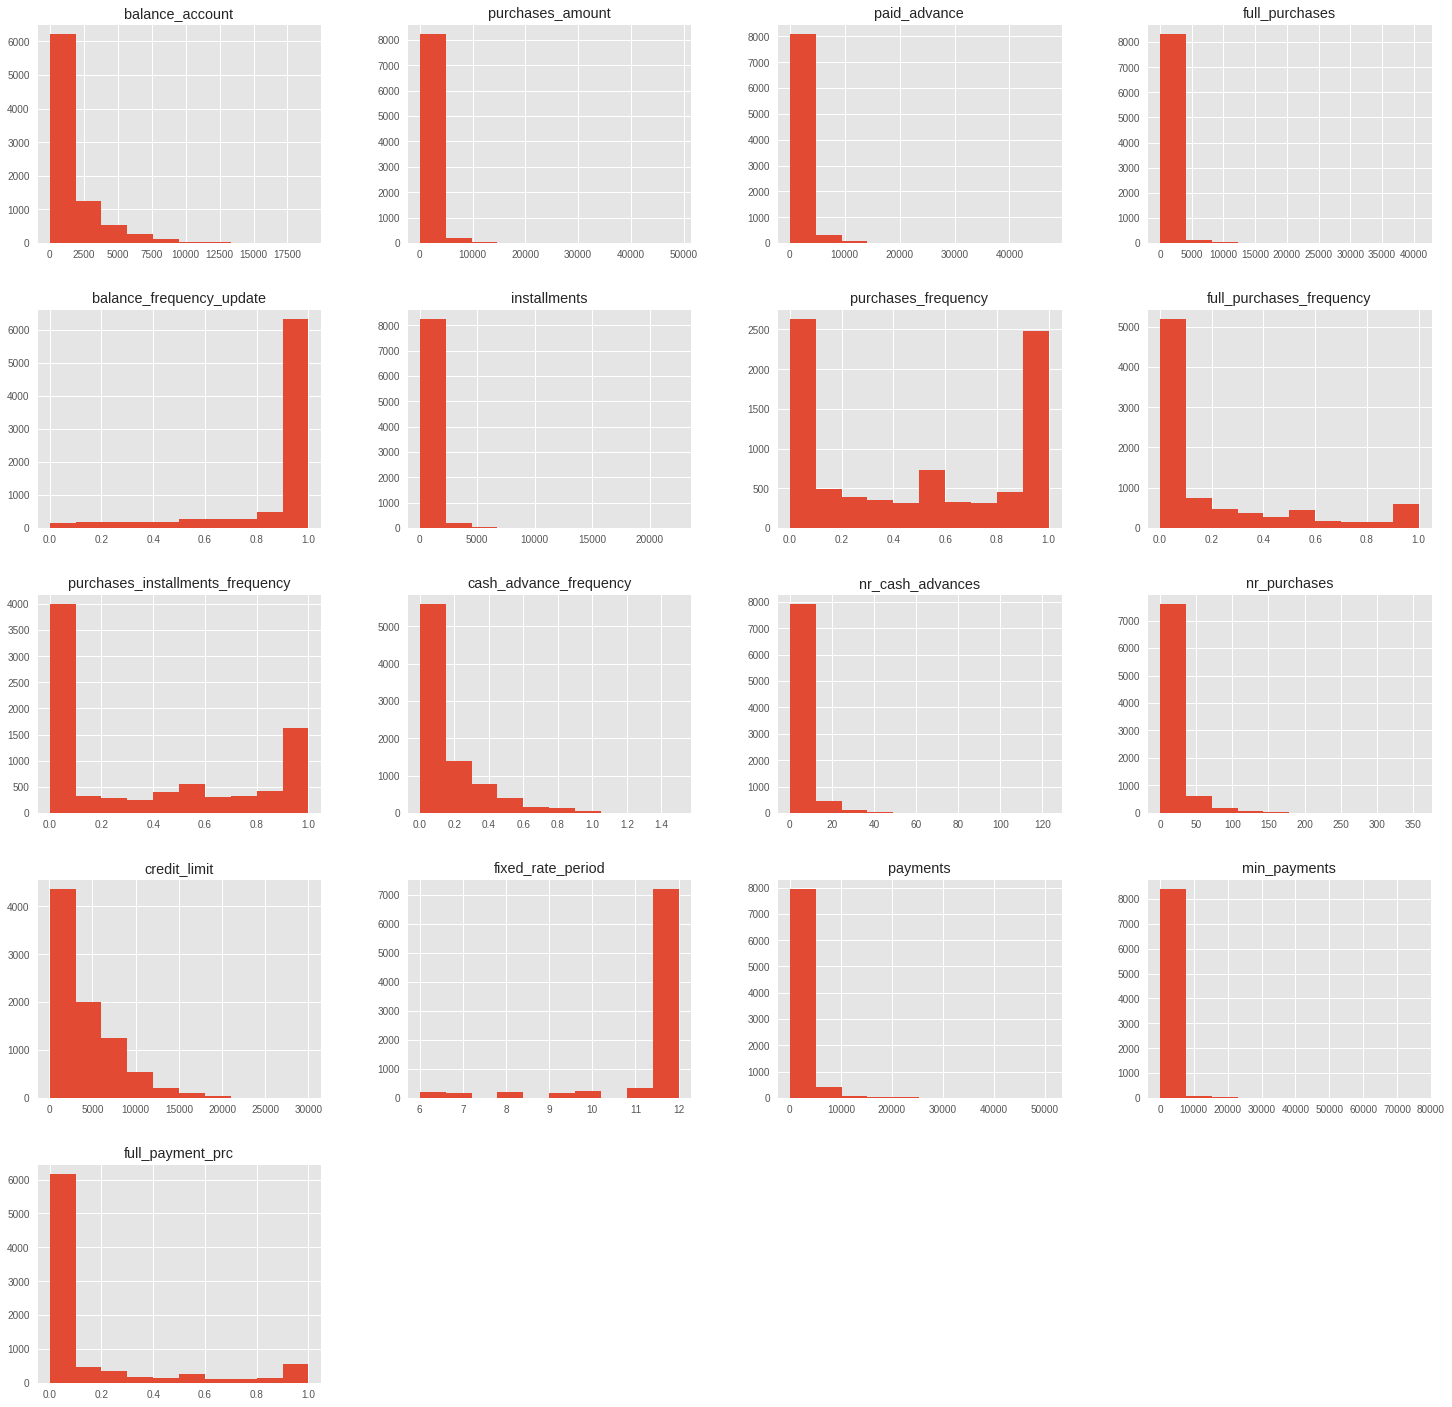

In [ ]:
df_clean.hist(figsize=(25, 25))
plt.show()

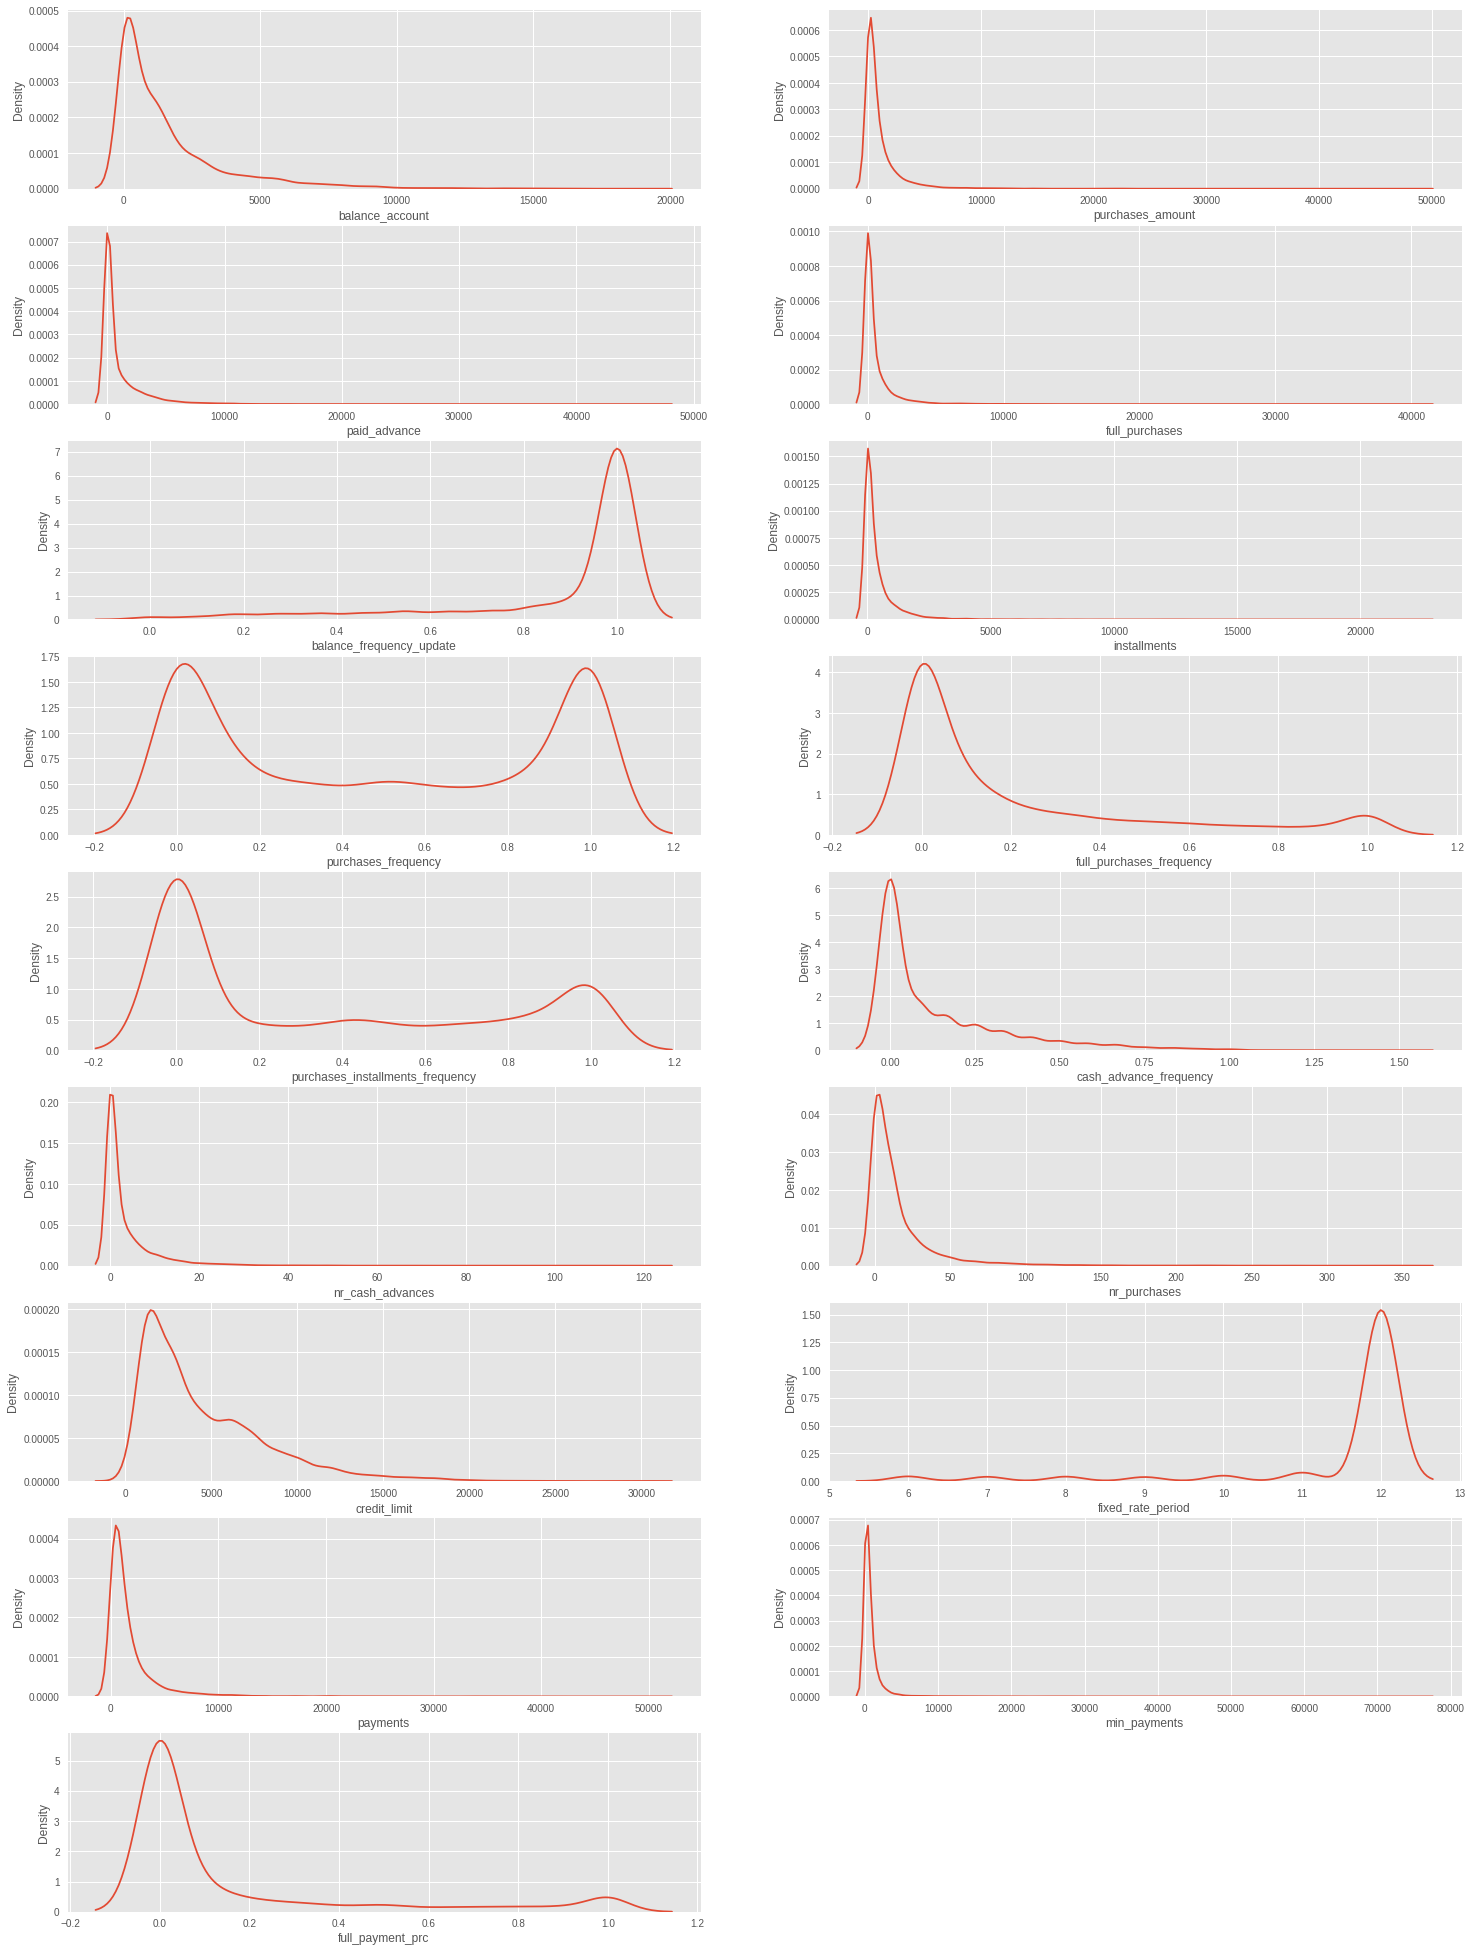

In [ ]:
plt.figure(figsize=(25,35))
for i, col in enumerate(df_clean.columns):
        ax = plt.subplot(9, 2, i+1)
        sns.kdeplot(df_clean[col], ax=ax)
        plt.xlabel(col)
        
plt.show()

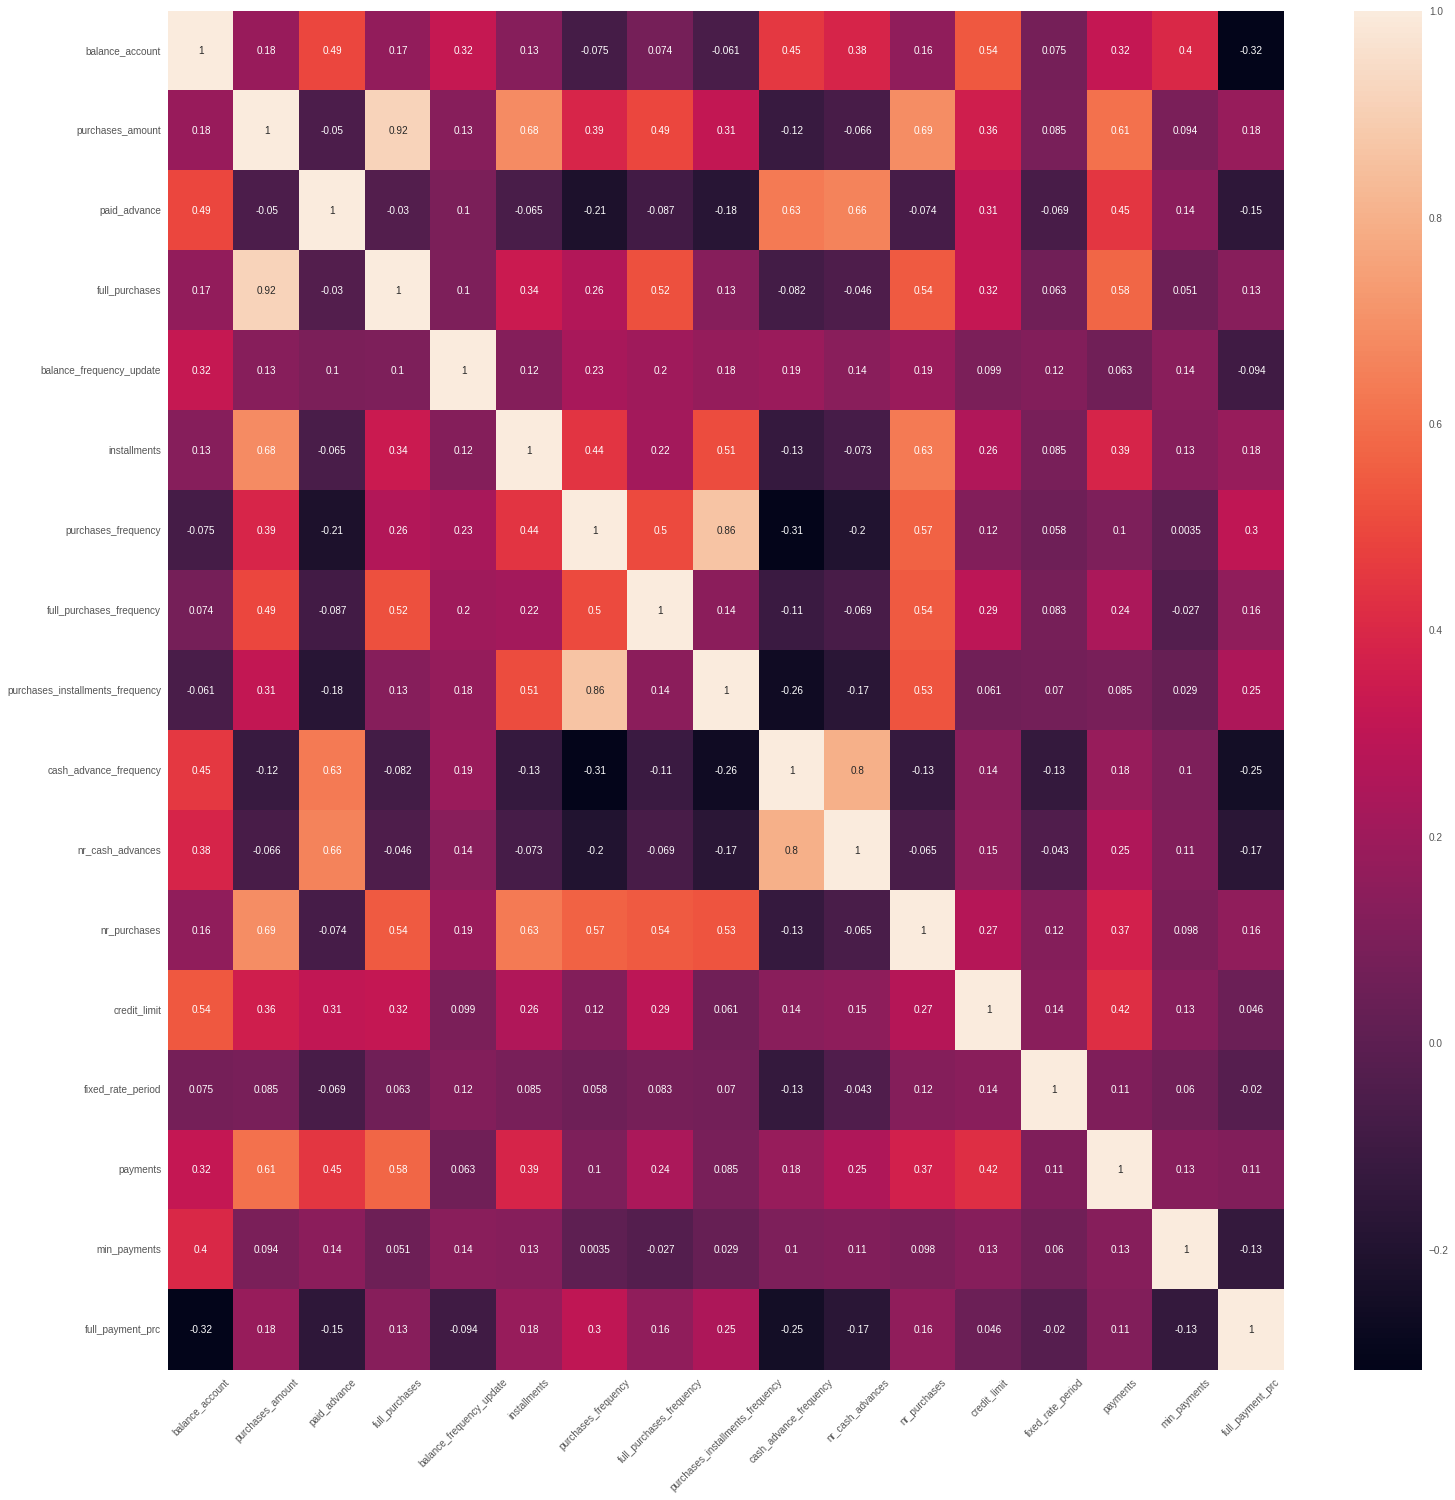

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(df_clean.corr(),annot=True,)
plt.xticks(rotation=45)
plt.show()

### Boxplot (cleaned + (SS vs PT vs RB))

#### Scaling SS vs PT vs RB

In [ ]:
# numeric transformer
# StandardScaler() to scale the numeric features

df_pre_ss = df_clean.copy(deep=True)
ss = StandardScaler()
df_ss = ss.fit_transform(df_pre_ss)

In [ ]:
df_ss = pd.DataFrame(data=df_ss, columns=df_pre_ss.columns)
df_ss.head(3)

balance_account  purchases_amount  paid_advance  full_purchases  \
0        -0.744733         -0.414119     -0.468410       -0.352351   
1        -0.723988         -0.394297     -0.468410       -0.352351   
2        -0.098222         -0.464069     -0.245723       -0.352351   

   balance_frequency_update  installments  purchases_frequency  \
0                  0.137896     -0.334190             1.046406   
1                  0.520844     -0.287274             1.273089   
2                  0.520844     -0.452415            -1.220429   

   full_purchases_frequency  purchases_installments_frequency  \
0                 -0.678304                          1.144031   
1                 -0.678304                          1.182181   
2                 -0.678304                         -0.916142   

   cash_advance_frequency  nr_cash_advances  nr_purchases  credit_limit  \
0               -0.673420         -0.474688     -0.187144     -0.960397   
1               -0.673420         -0.474688     -0.347137     -0.960397   
2                0.684165          0.400606     -0.587127     -0.822641   

   fixed_rate_period  payments  min_payments  full_payment_prc  
0          -0.386286 -0.563949     -0.323316          0.946708  
1          -4.123811 -0.576097     -0.326175         -0.523515  
2          -0.386286 -0.490270     -0.173499         -0.523515

In [ ]:
df_scaled_ss = df_ss.copy(deep=True)

In [ ]:
# numeric transformer
# PowerTransformer() to scale the numeric features

df_pre_pt = df_clean.copy(deep=True)
pt = PowerTransformer()
df_pt = pt.fit_transform(df_pre_pt)

In [ ]:
df_pt = pd.DataFrame(data=df_pt, columns=df_pre_pt.columns)
df_pt.head(3)

balance_account  purchases_amount  paid_advance  full_purchases  \
0        -1.643655         -0.323201     -0.942774       -1.000226   
1        -1.148825         -0.198960     -0.942774       -1.000226   
2         0.435196         -1.505422      0.871682       -1.000226   

   balance_frequency_update  installments  purchases_frequency  \
0                 -0.414711      0.423890             1.037321   
1                  0.630996      0.532709             1.221094   
2                  0.630996     -1.084691            -1.278203   

   full_purchases_frequency  purchases_installments_frequency  \
0                 -0.903417                          1.165068   
1                 -0.903417                          1.184716   
2                 -0.903417                         -1.003679   

   cash_advance_frequency  nr_cash_advances  nr_purchases  credit_limit  \
0               -0.881439         -0.904176      0.377953     -1.418899   
1               -0.881439         -0.904176      0.049992     -1.418899   
2                1.202273          1.246923     -1.387627     -0.952622   

   fixed_rate_period  payments  min_payments  full_payment_prc  
0          -1.916622 -1.391850     -1.174106          1.673299  
1          -2.521817 -1.610669     -1.243891         -0.675354  
2          -1.916622 -0.750086      0.198940         -0.675354

In [ ]:
df_scaled_pt = df_pt.copy(deep=True)

In [ ]:
# numeric transformer
# MinMaxScaler() to scale the numeric features

df_pre_mm = df_clean.copy(deep=True)
mm = MinMaxScaler()
df_mm = mm.fit_transform(df_pre_mm)

In [ ]:
df_mm = pd.DataFrame(data=df_mm, columns=df_pre_mm.columns)
df_mm.head(3)

balance_account  purchases_amount  paid_advance  full_purchases  \
0         0.000488          0.002194      0.000000             0.0   
1         0.002766          0.003065      0.000000             0.0   
2         0.071459          0.000000      0.009819             0.0   

   balance_frequency_update  installments  purchases_frequency  \
0                  0.909091      0.004782             0.909091   
1                  1.000000      0.006680             1.000000   
2                  1.000000      0.000000             0.000000   

   full_purchases_frequency  purchases_installments_frequency  \
0                       0.0                          0.818182   
1                       0.0                          0.833333   
2                       0.0                          0.000000   

   cash_advance_frequency  nr_cash_advances  nr_purchases  credit_limit  \
0                0.000000           0.00000      0.027933      0.031720   
1                0.000000           0.00000      0.016760      0.031720   
2                0.181818           0.04878      0.000000      0.048414   

   fixed_rate_period  payments  min_payments  full_payment_prc  
0           0.833333  0.001772      0.001174          0.428571  
1           0.000000  0.001079      0.001085          0.000000  
2           0.833333  0.005974      0.005808          0.000000

In [ ]:
df_scaled_mm = df_mm.copy(deep=True)

#### Boxplot plotting

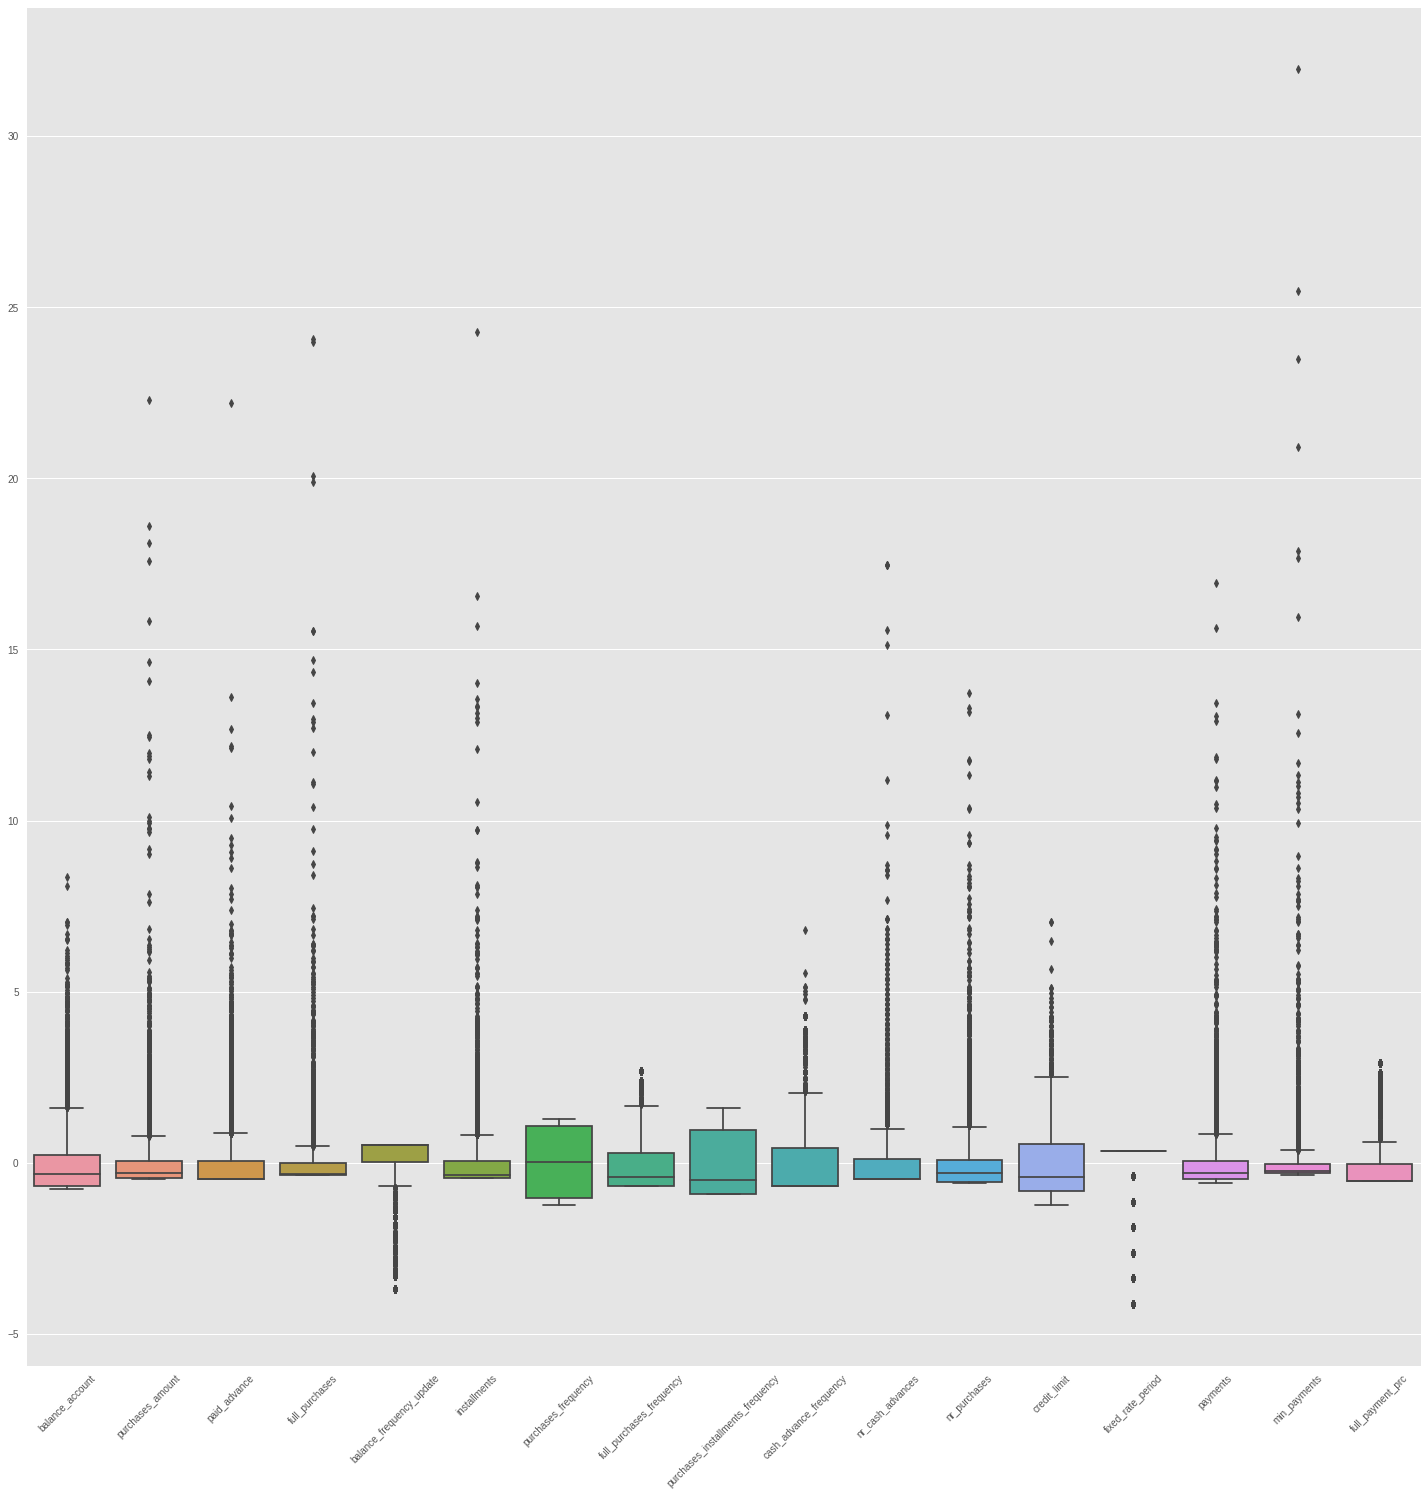

In [ ]:
# w/ StandardScaler()

plt.figure(figsize=(25,25))
ax = sns.boxplot(data=df_scaled_ss)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

# large number of outliers for many features

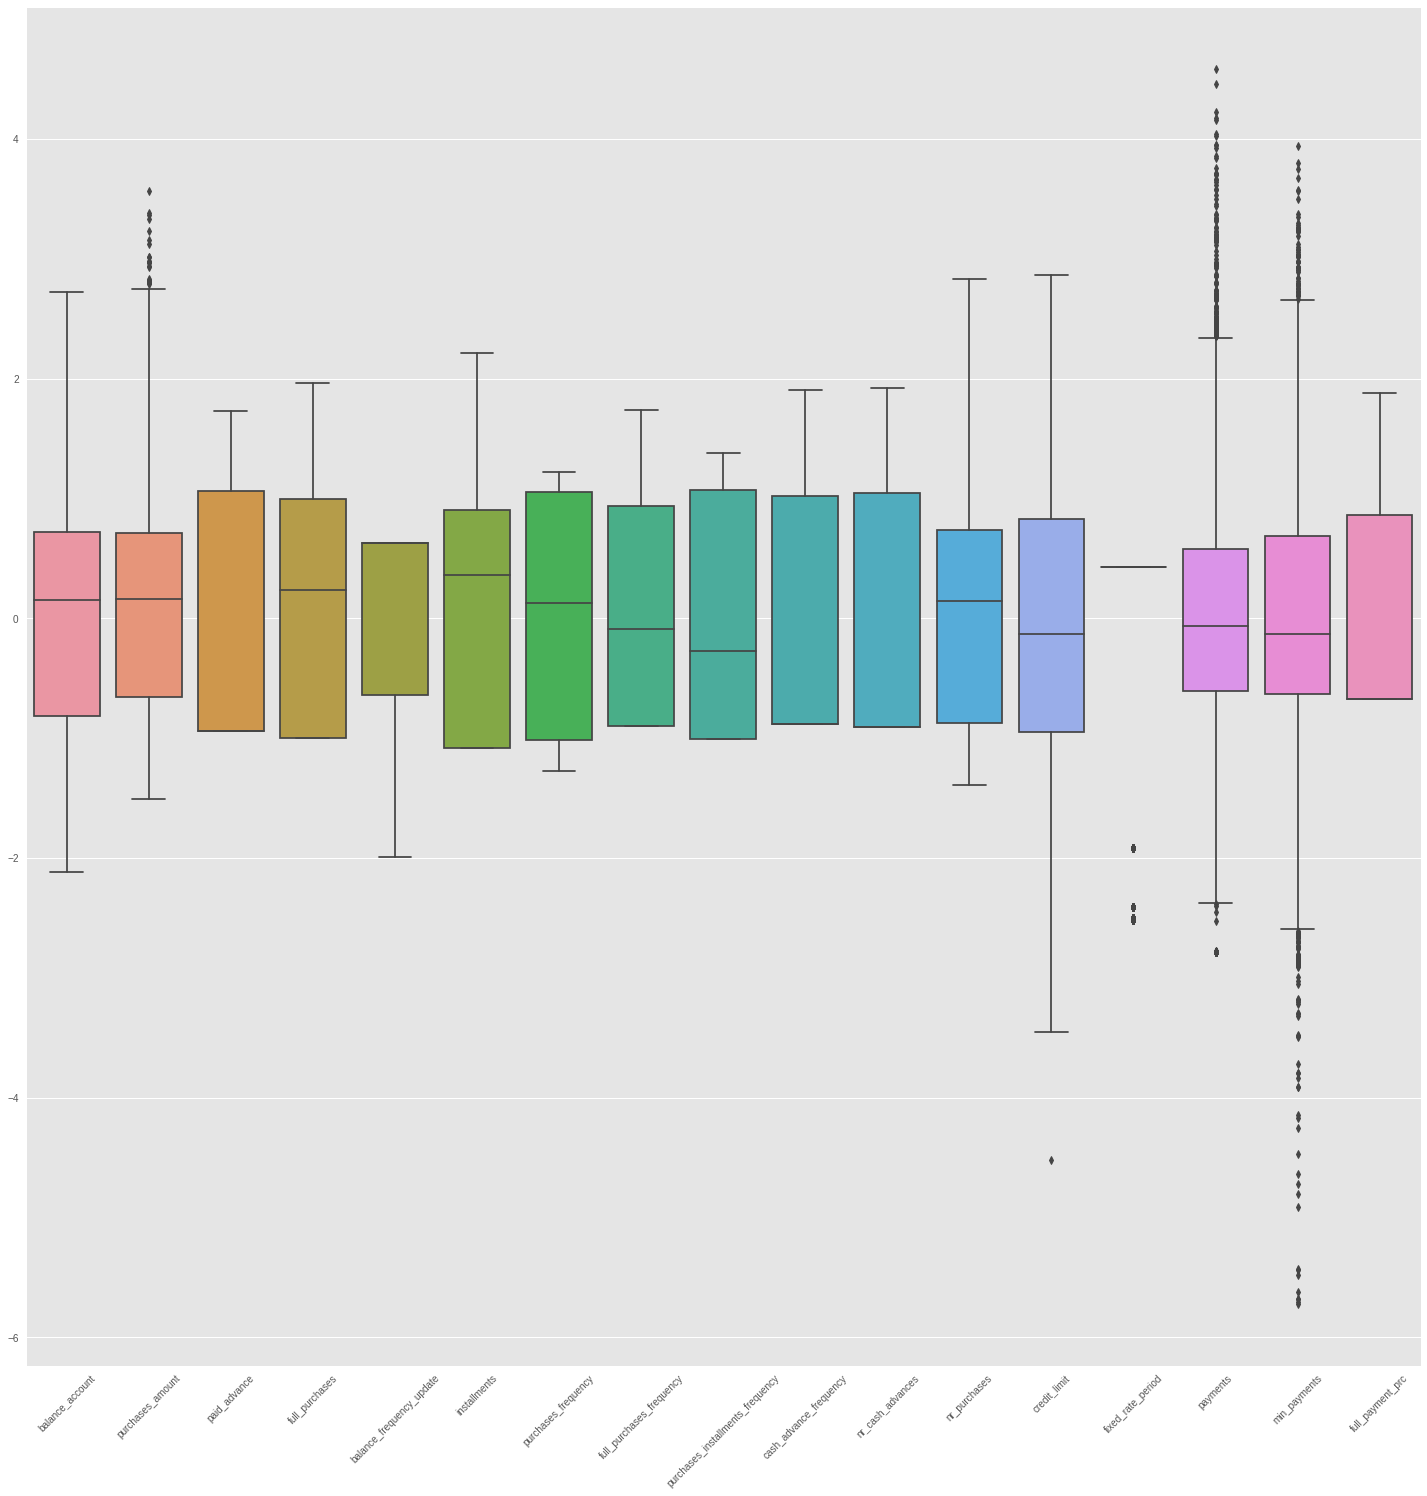

In [ ]:
# w/ PowerTransformer()

plt.figure(figsize=(25,25))
ax = sns.boxplot(data=df_scaled_pt)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

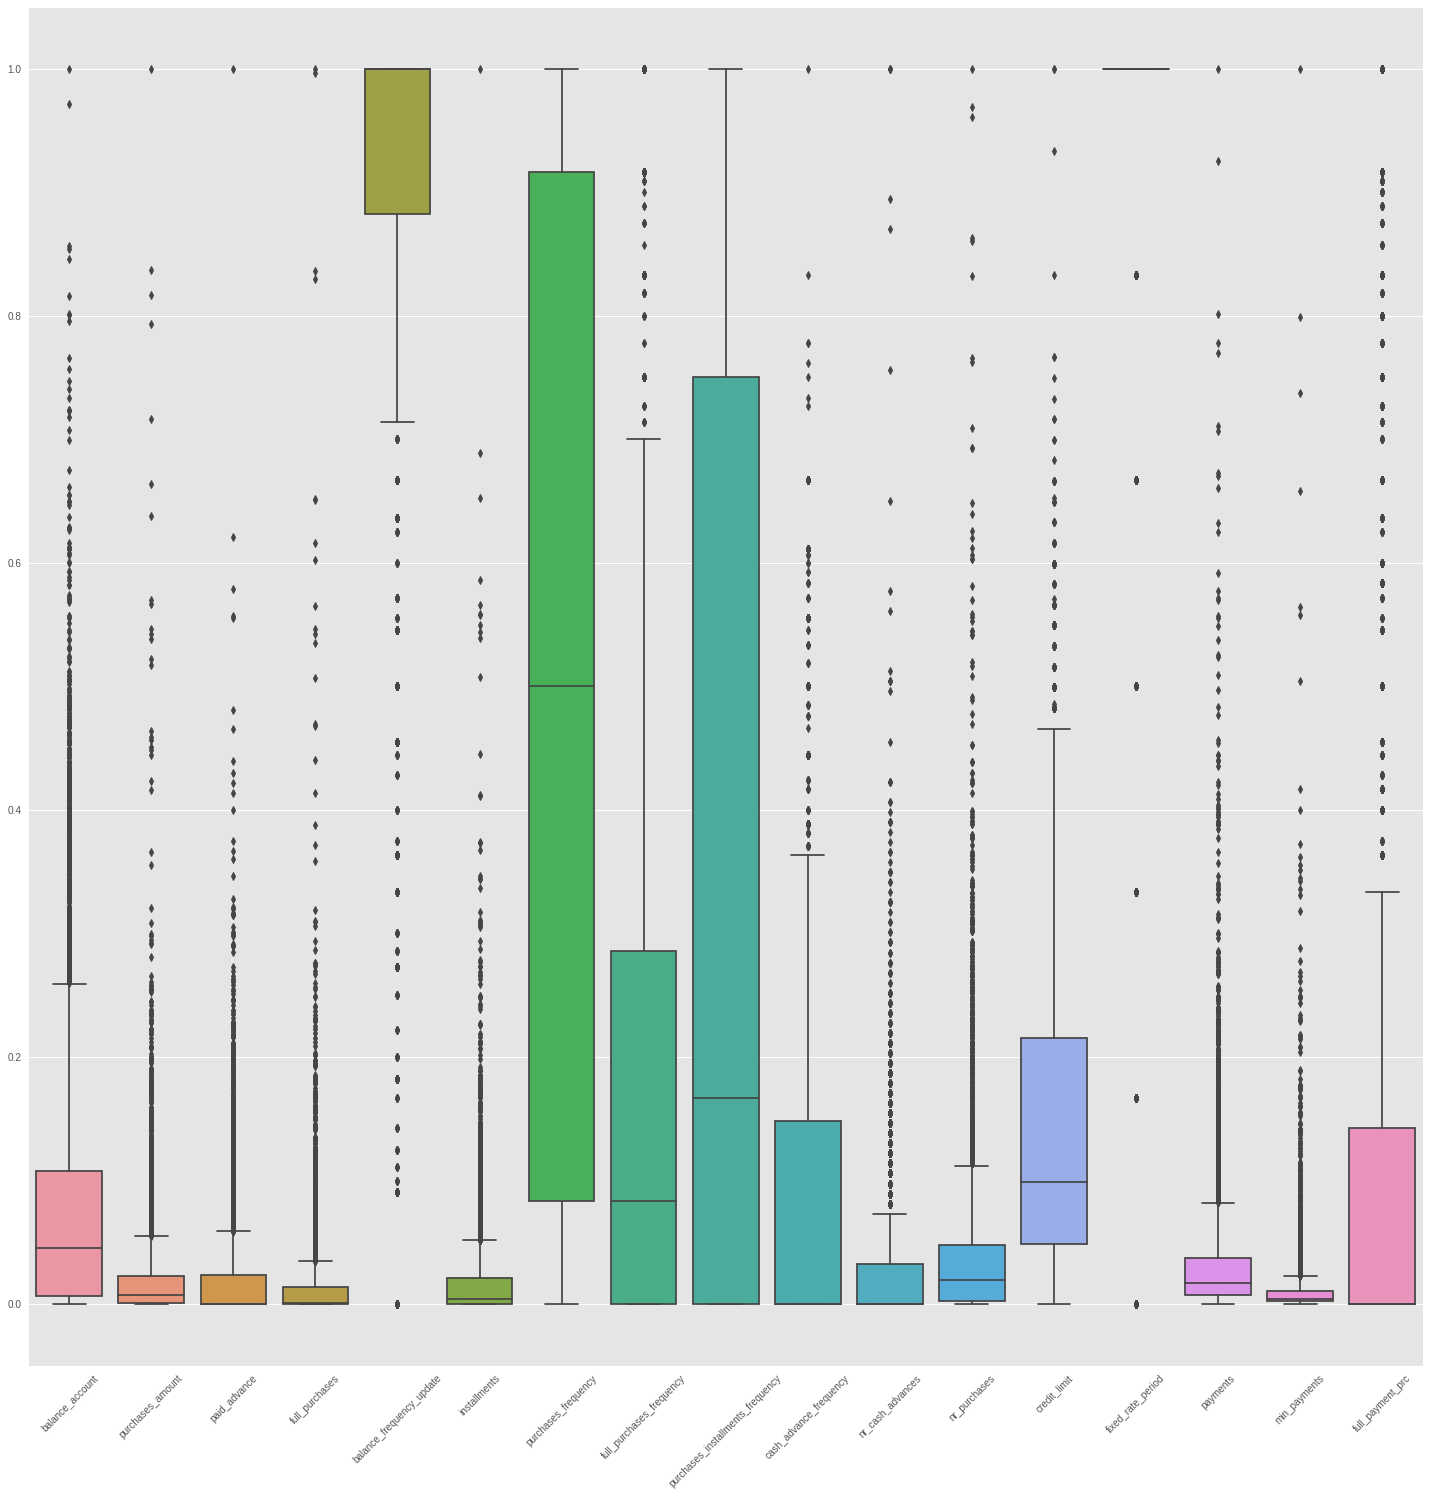

In [ ]:
# w/ MinMaxScaler()

plt.figure(figsize=(25,25))
ax = sns.boxplot(data=df_scaled_mm)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

# Cleaned data

In [ ]:
# df                => initial
# df_clean          => initial => KNNImputer
# df_scaled_ss      => initial => KNNImputer => StandardScaler
# df_sclaed_pt      => initial => KNNImputer => PowerTransformer
# df_scaled_mm      => initial => KNNImputer => PowerTransformer

## Data for clustering

In [ ]:
data_clean = df_clean.copy(deep=True)

## Clustering analysis SS

### K-Means computation

In [ ]:
r_seed = 99

In [ ]:
# want to select the optimal number of clusters

cluster_errors = []

for i in range(1, 15):
    n_clusters = i
    kmeans_pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "cluster",
                KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0, 
                       # n_jobs=1
                      ),
            ),
        ]
    )
    kmeans_pipeline.fit(data_clean)
    kmeans_pipeline.predict(data_clean)
    cluster_errors.append(kmeans_pipeline.named_steps["cluster"].inertia_)

### Elbow method

In [ ]:
# fast approach

# plt.clf()
# plt.plot(cluster_errors, "o-")
# plt.xlabel("n_clusters")
# plt.ylabel("sum sq distances from mean")
# plt.show()

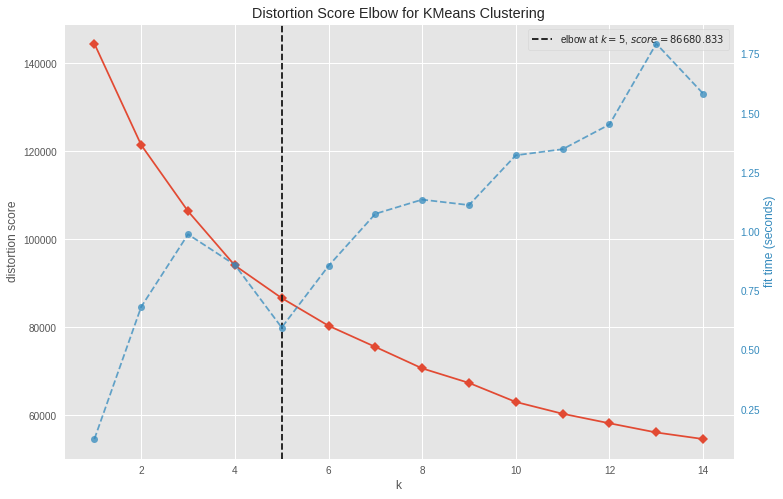

In [ ]:
# list with features
features = list(data_clean.columns)

# setting up the content of variable 'X':
X = data_clean.loc[:,features].values
ss = StandardScaler()

# numeric_transformer = Pipeline(steps=[('onehot', StandardScaler()),('imputer', SimpleImputer(strategy='mean'))])
# numeric_features = list(range(len(features)))

# feature_encoder = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

X = ss.fit_transform(X)

# clustering model and visualizer
model = KMeans(random_state=r_seed, verbose=0)
visualizer = KElbowVisualizer(model, k=(1,15))
visualizer.fit(X) # fit the data to the visualizer
visualizer.poof(); # draw/show/poof the data

### Silhouette method

For n_clusters = 3 The average silhouette_score is : 0.34176874
For n_clusters = 4 The average silhouette_score is : 0.052178357
For n_clusters = 5 The average silhouette_score is : -0.0017458741
For n_clusters = 6 The average silhouette_score is : 0.0028378468
For n_clusters = 7 The average silhouette_score is : 0.0008127535
For n_clusters = 8 The average silhouette_score is : -0.067875




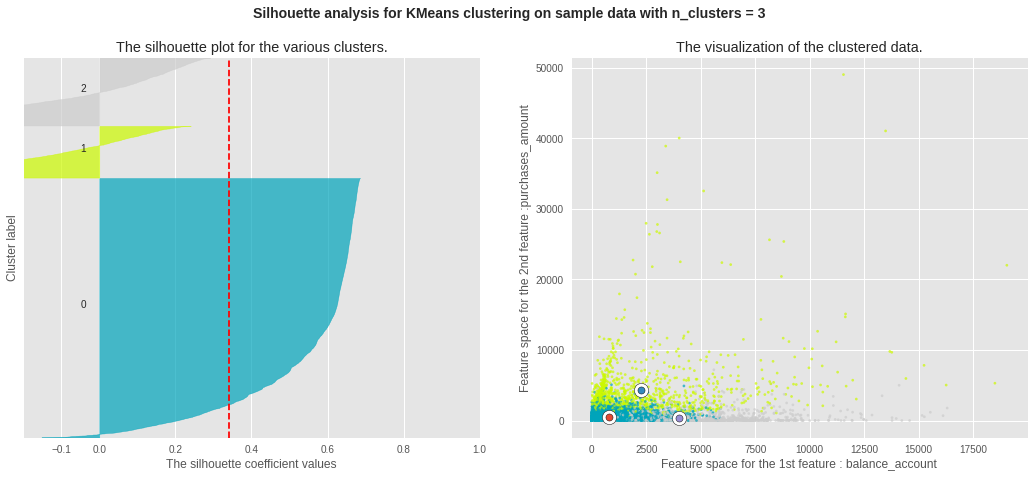

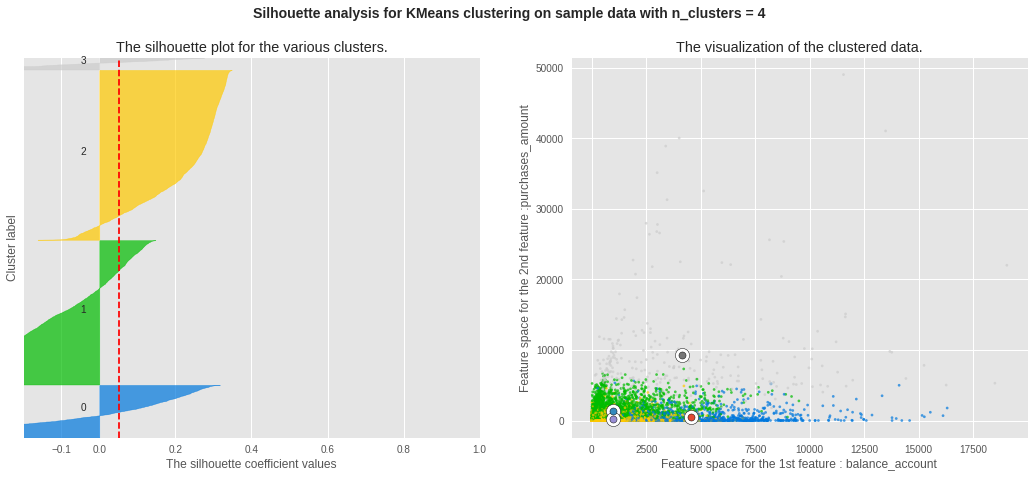

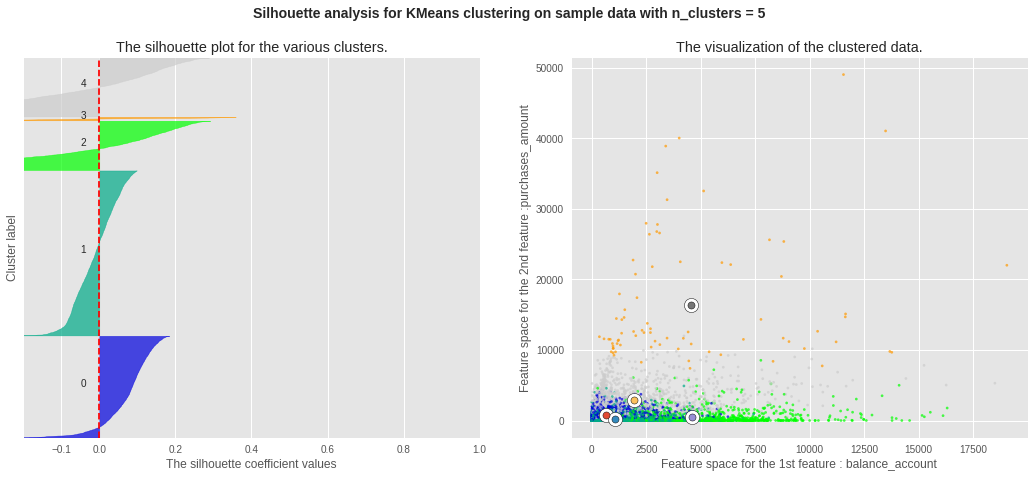

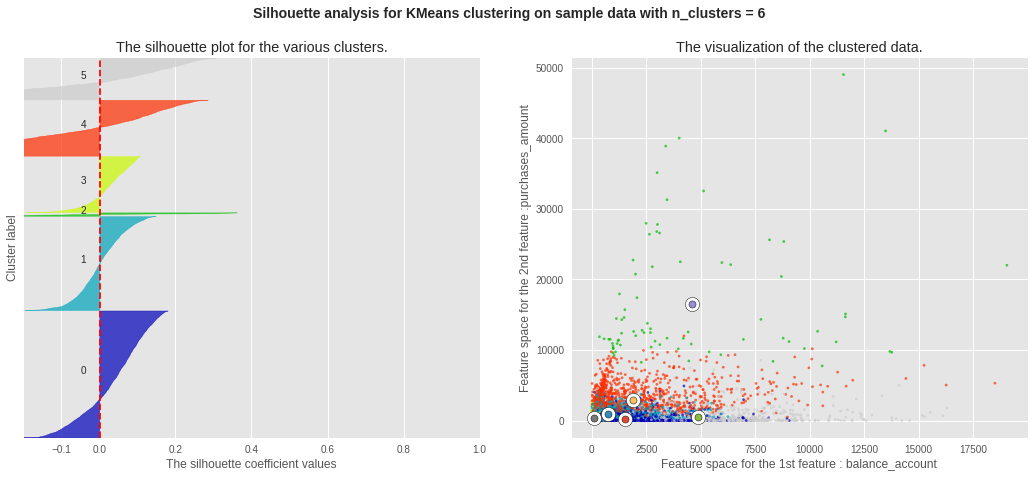

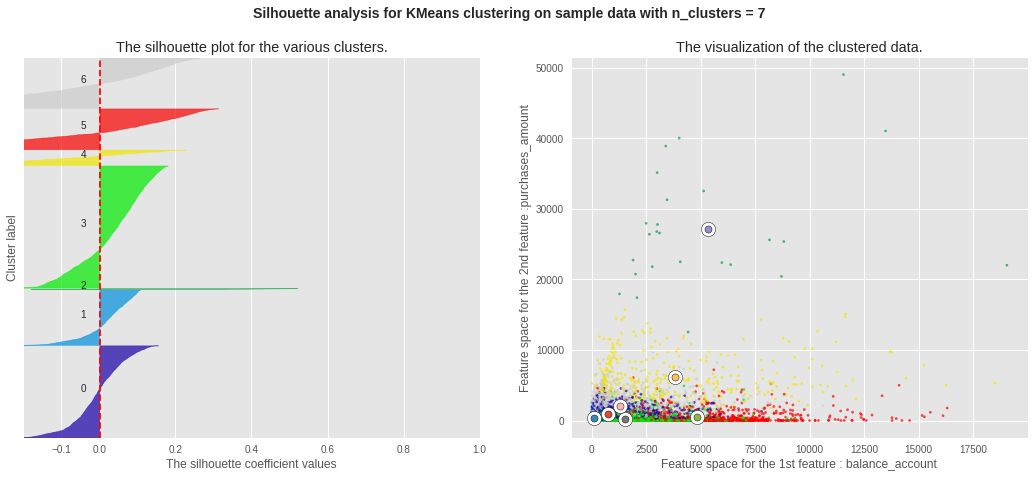

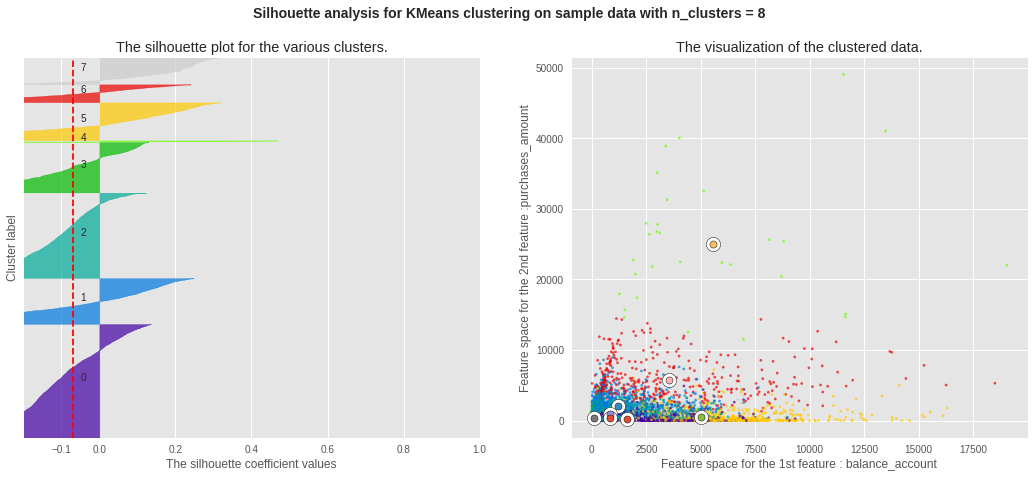

In [ ]:
range_n_clusters = range(3, 9)
X = data_clean.copy()
X = X.values.astype("float32")
cols = data_clean.columns

for n_clusters in range_n_clusters:

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility.
    # THIS PIPELINE IS NOT INCLUDED IN THE SCIKIT LEARN DOCUMENTATION
    kmeans_pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "cluster",
                KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0),
            ),
        ]
    )
    cluster_labels = kmeans_pipeline.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i + 1) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k",
    )

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature : " + cols[0])
    ax2.set_ylabel("Feature space for the 2nd feature :" + cols[1])

    plt.suptitle(
        (
            "Silhouette analysis for KMeans clustering on sample data "
            "with n_clusters = %d" % n_clusters
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")
plt.show()

In [ ]:
data_clean.columns

Index(['balance_account', 'purchases_amount', 'paid_advance', 'full_purchases',
       'balance_frequency_update', 'installments', 'purchases_frequency',
       'full_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'nr_cash_advances', 'nr_purchases',
       'credit_limit', 'fixed_rate_period', 'payments', 'min_payments',
       'full_payment_prc'],
      dtype='object')

## n_clusters = 3 SS

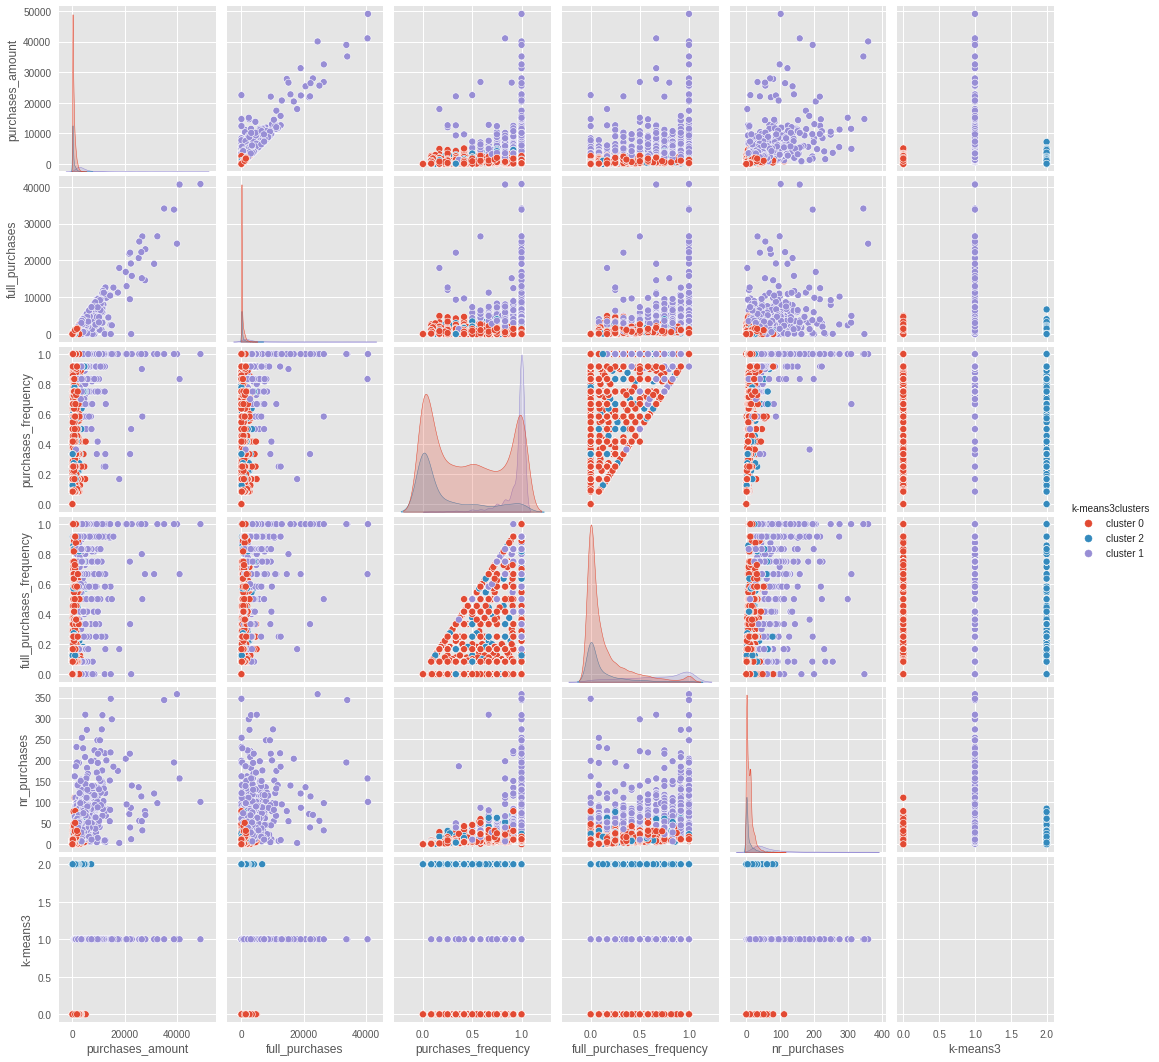

In [ ]:
# set features 1

n_clusters = 3
kmeans_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)),
    ]
)
kmeans_pipeline.fit(data_clean)
labels = kmeans_pipeline.predict(data_clean)
centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_

cols = ['purchases_amount', 'full_purchases', 'purchases_frequency',
       'full_purchases_frequency', 'nr_purchases']

# cols = ['balance_account', 'balance_frequency_update', 'payments', 'min_payments',
#        'full_payment_prc', 'paid_advance']

# cols = ['installments', 'purchases_installments_frequency',
#        'cash_advance_frequency', 'nr_cash_advances',
#        'credit_limit', 'fixed_rate_period']

kmeans_pipeline.fit(data_clean[cols])
data_kmeans = data_clean[cols].copy()
data_kmeans["k-means3"] = labels
data_kmeans["k-means3clusters"] = data_kmeans["k-means3"].map(
    lambda i: "cluster " + str(i)
)

cols = ['purchases_amount', 'full_purchases', 'purchases_frequency',
       'full_purchases_frequency', 'nr_purchases', "k-means3clusters"]

# cols = ['balance_account', 'balance_frequency_update', 'payments', 'min_payments',
#        'full_payment_prc', 'paid_advance', "k-means3clusters"]

# cols = ['installments', 'purchases_installments_frequency',
#        'cash_advance_frequency', 'nr_cash_advances',
#        'credit_limit', 'fixed_rate_period', "k-means3clusters"]

g1 = sns.pairplot(data_kmeans, hue="k-means3clusters")
g1.fig.figsize = (25, 25)

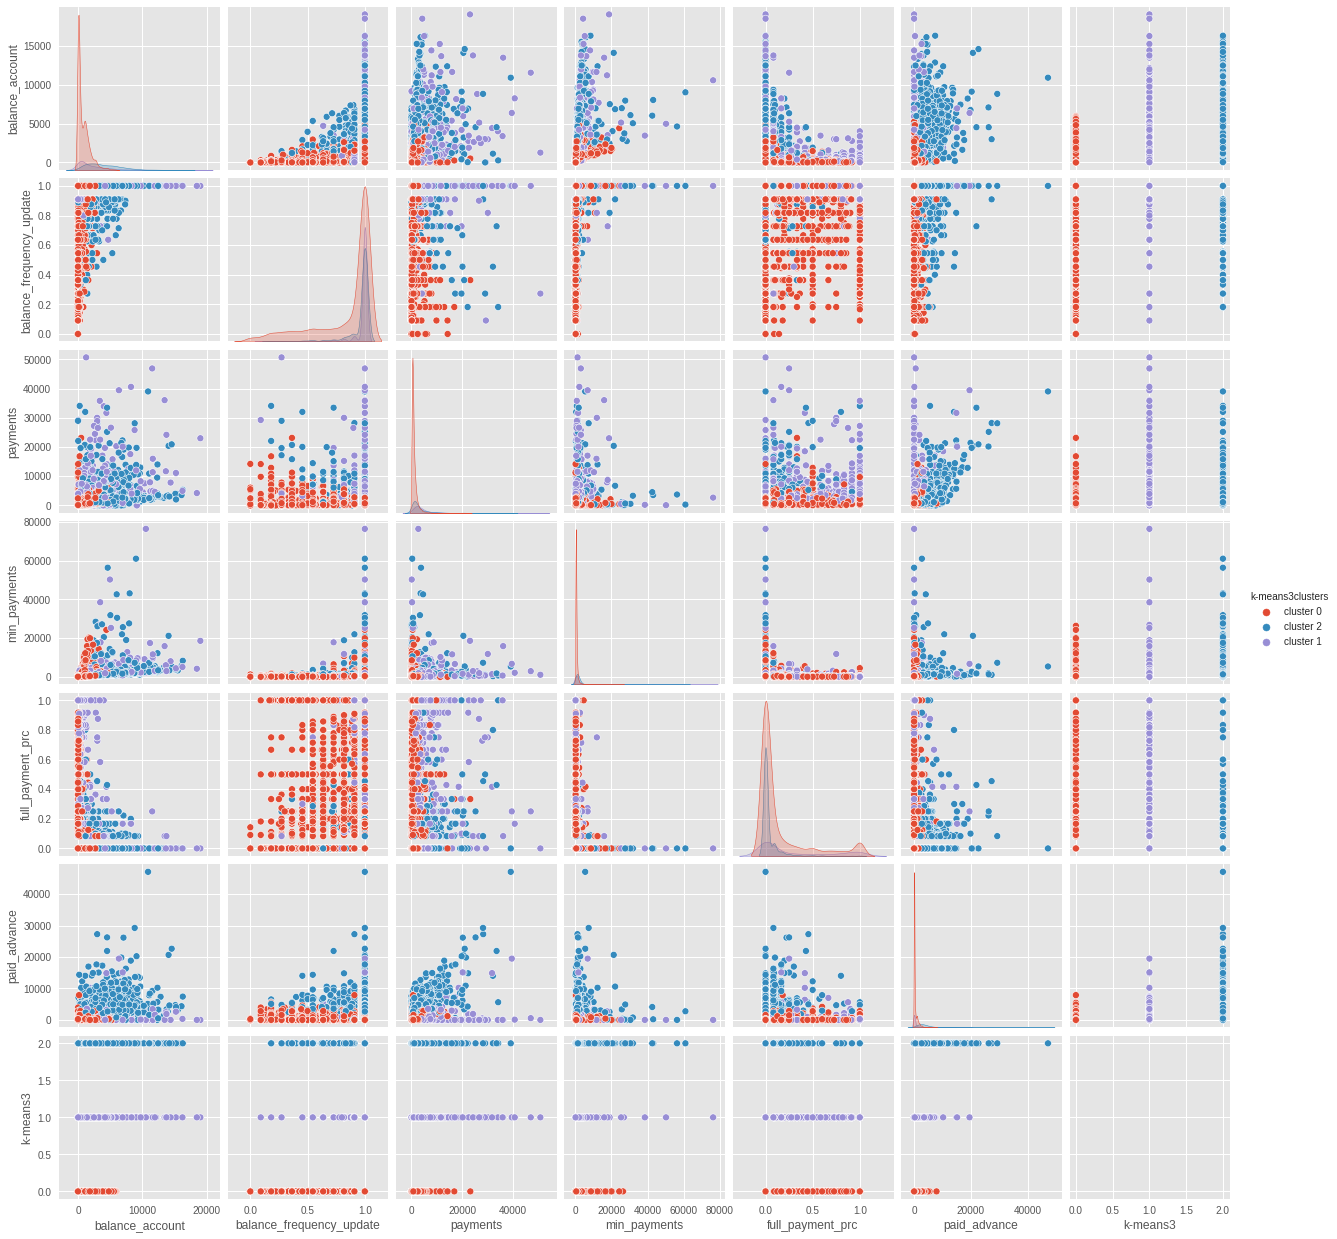

In [ ]:
# set features 2

n_clusters = 3
kmeans_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)),
    ]
)
kmeans_pipeline.fit(data_clean)
labels = kmeans_pipeline.predict(data_clean)
centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_

# cols = ['purchases_amount', 'full_purchases', 'purchases_frequency',
#        'full_purchases_frequency', 'nr_purchases']

cols = ['balance_account', 'balance_frequency_update', 'payments', 'min_payments',
       'full_payment_prc', 'paid_advance']

# cols = ['installments', 'purchases_installments_frequency',
#        'cash_advance_frequency', 'nr_cash_advances',
#        'credit_limit', 'fixed_rate_period']

kmeans_pipeline.fit(data_clean[cols])
data_kmeans = data_clean[cols].copy()
data_kmeans["k-means3"] = labels
data_kmeans["k-means3clusters"] = data_kmeans["k-means3"].map(
    lambda i: "cluster " + str(i)
)

# cols = ['purchases_amount', 'full_purchases', 'purchases_frequency',
#        'full_purchases_frequency', 'nr_purchases', "k-means3clusters"]

cols = ['balance_account', 'balance_frequency_update', 'payments', 'min_payments',
       'full_payment_prc', 'paid_advance', "k-means3clusters"]

# cols = ['installments', 'purchases_installments_frequency',
#        'cash_advance_frequency', 'nr_cash_advances',
#        'credit_limit', 'fixed_rate_period', "k-means3clusters"]

g1 = sns.pairplot(data_kmeans, hue="k-means3clusters")
g1.fig.figsize = (25, 25)

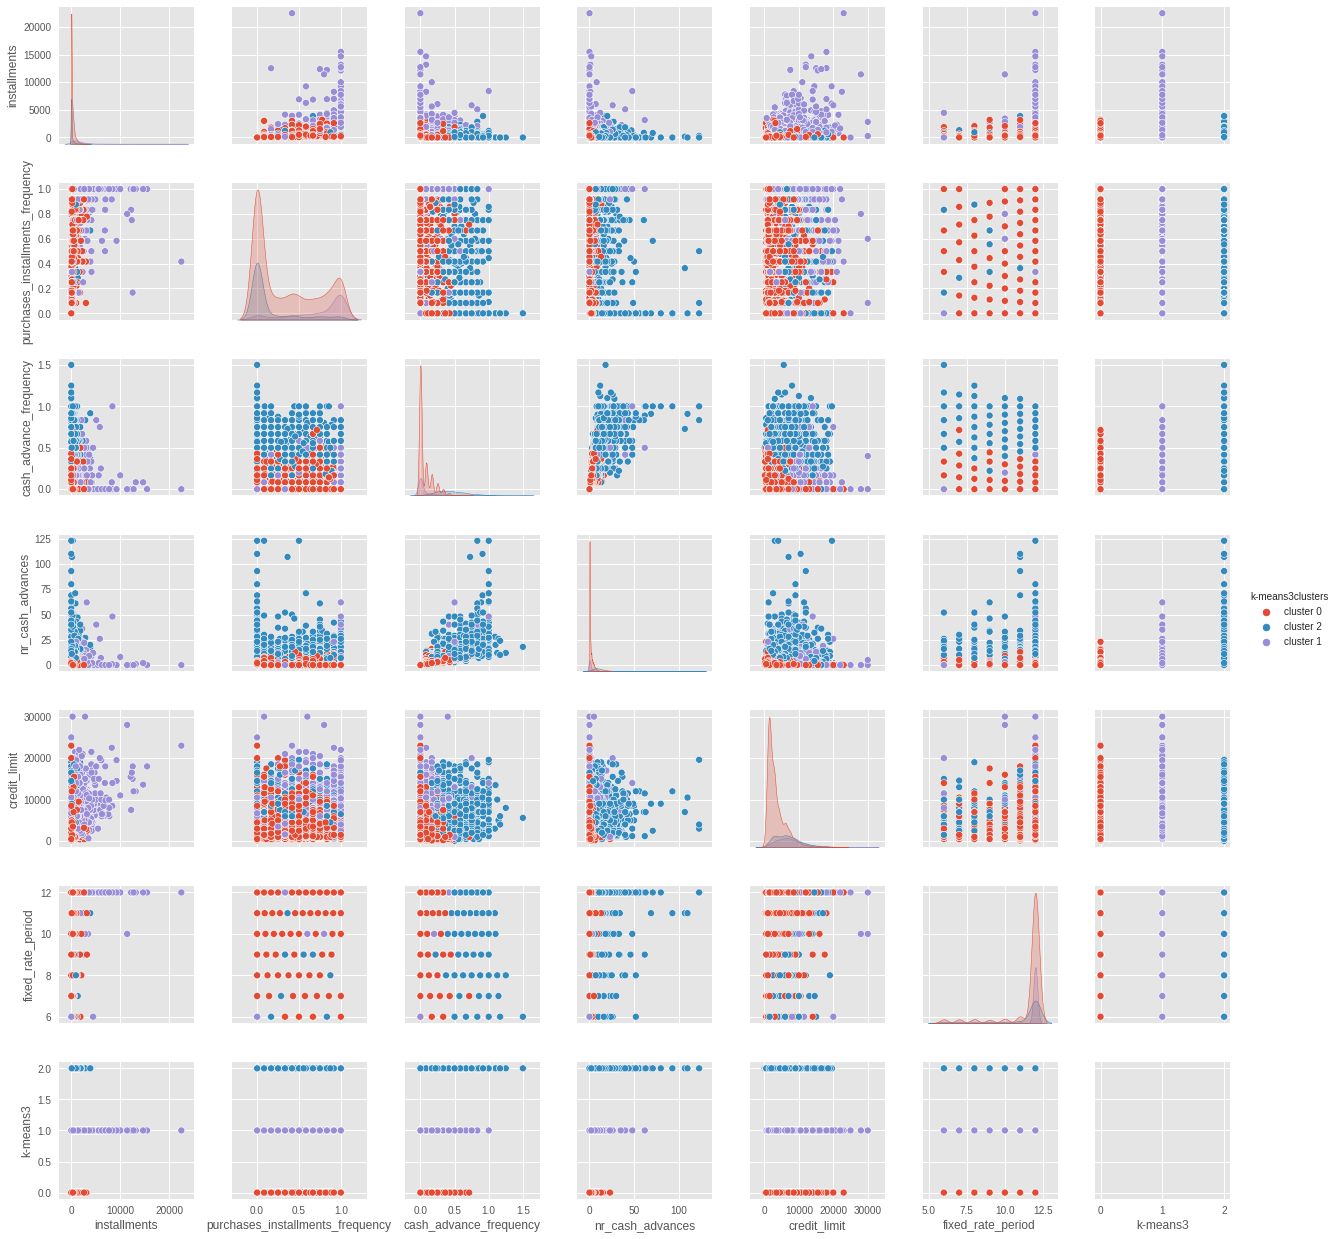

In [ ]:
# set features 3

n_clusters = 3
kmeans_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)),
    ]
)
kmeans_pipeline.fit(data_clean)
labels = kmeans_pipeline.predict(data_clean)
centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_

# cols = ['purchases_amount', 'full_purchases', 'purchases_frequency',
#        'full_purchases_frequency', 'nr_purchases']

# cols = ['balance_account', 'balance_frequency_update', 'payments', 'min_payments',
#        'full_payment_prc', 'paid_advance']

cols = ['installments', 'purchases_installments_frequency',
       'cash_advance_frequency', 'nr_cash_advances',
       'credit_limit', 'fixed_rate_period']

kmeans_pipeline.fit(data_clean[cols])
data_kmeans = data_clean[cols].copy()
data_kmeans["k-means3"] = labels
data_kmeans["k-means3clusters"] = data_kmeans["k-means3"].map(
    lambda i: "cluster " + str(i)
)

# cols = ['purchases_amount', 'full_purchases', 'purchases_frequency',
#        'full_purchases_frequency', 'nr_purchases', "k-means3clusters"]

# cols = ['balance_account', 'balance_frequency_update', 'payments', 'min_payments',
#        'full_payment_prc', 'paid_advance', "k-means3clusters"]

cols = ['installments', 'purchases_installments_frequency',
       'cash_advance_frequency', 'nr_cash_advances',
       'credit_limit', 'fixed_rate_period', "k-means3clusters"]

g1 = sns.pairplot(data_kmeans, hue="k-means3clusters")
g1.fig.figsize = (25, 25)

In [ ]:
df_cust = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML_day_9_10/data/card_transactions.csv")

In [ ]:
cust_id = df_cust['customer_id']

In [ ]:
from matplotlib.colors import LogNorm

df_scaled_ss["customer_id"] = cust_id.astype(str)
# plt.style.use('default')
data_copy = df_scaled_ss.copy()
data_copy["k-means3"] = data_kmeans["k-means3"]
data_copy["k-means3_01"] = 10^(data_kmeans["k-means3"])
plt.figure(figsize=(30,30))
sns.heatmap(data_copy.sort_values(by="k-means3").drop(columns=["customer_id","k-means3"]), 
            norm=LogNorm()
           );

KeyError: ignored

## n_clusters = 4 SS

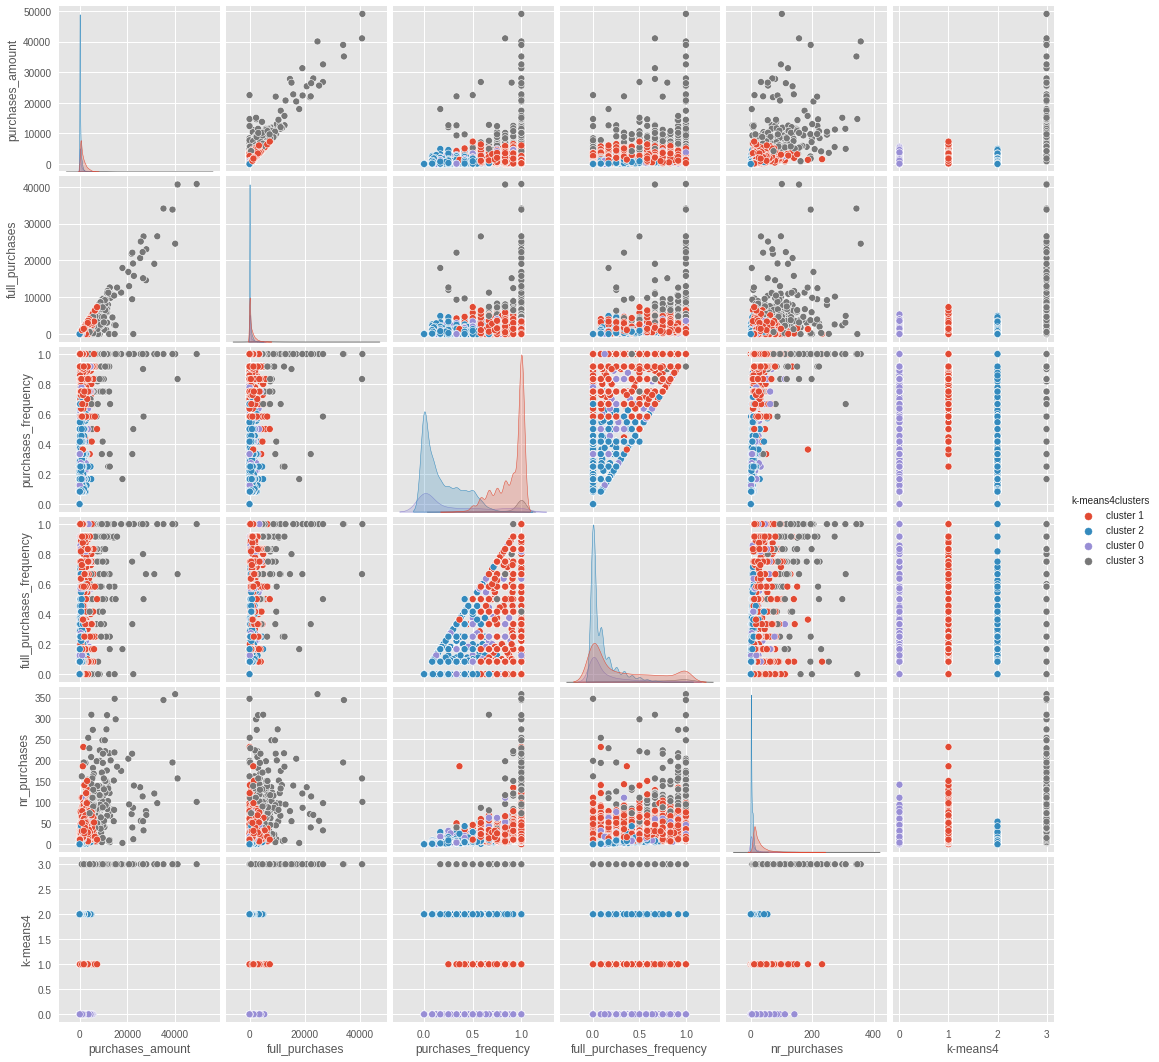

In [ ]:
# set features 1

n_clusters = 4
kmeans_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)),
    ]
)
kmeans_pipeline.fit(data_clean)
labels = kmeans_pipeline.predict(data_clean)
centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_

cols = ['purchases_amount', 'full_purchases', 'purchases_frequency',
       'full_purchases_frequency', 'nr_purchases']

# cols = ['balance_account', 'balance_frequency_update', 'payments', 'min_payments',
#        'full_payment_prc', 'paid_advance']

# cols = ['installments', 'purchases_installments_frequency',
#        'cash_advance_frequency', 'nr_cash_advances',
#        'credit_limit', 'fixed_rate_period']

kmeans_pipeline.fit(data_clean[cols])
data_kmeans = data_clean[cols].copy()
data_kmeans["k-means4"] = labels
data_kmeans["k-means4clusters"] = data_kmeans["k-means4"].map(
    lambda i: "cluster " + str(i)
)

cols = ['purchases_amount', 'full_purchases', 'purchases_frequency',
       'full_purchases_frequency', 'nr_purchases', "k-means3clusters"]

# cols = ['balance_account', 'balance_frequency_update', 'payments', 'min_payments',
#        'full_payment_prc', 'paid_advance', "k-means3clusters"]

# cols = ['installments', 'purchases_installments_frequency',
#        'cash_advance_frequency', 'nr_cash_advances',
#        'credit_limit', 'fixed_rate_period', "k-means3clusters"]

g1 = sns.pairplot(data_kmeans, hue="k-means4clusters")
g1.fig.figsize = (25, 25)

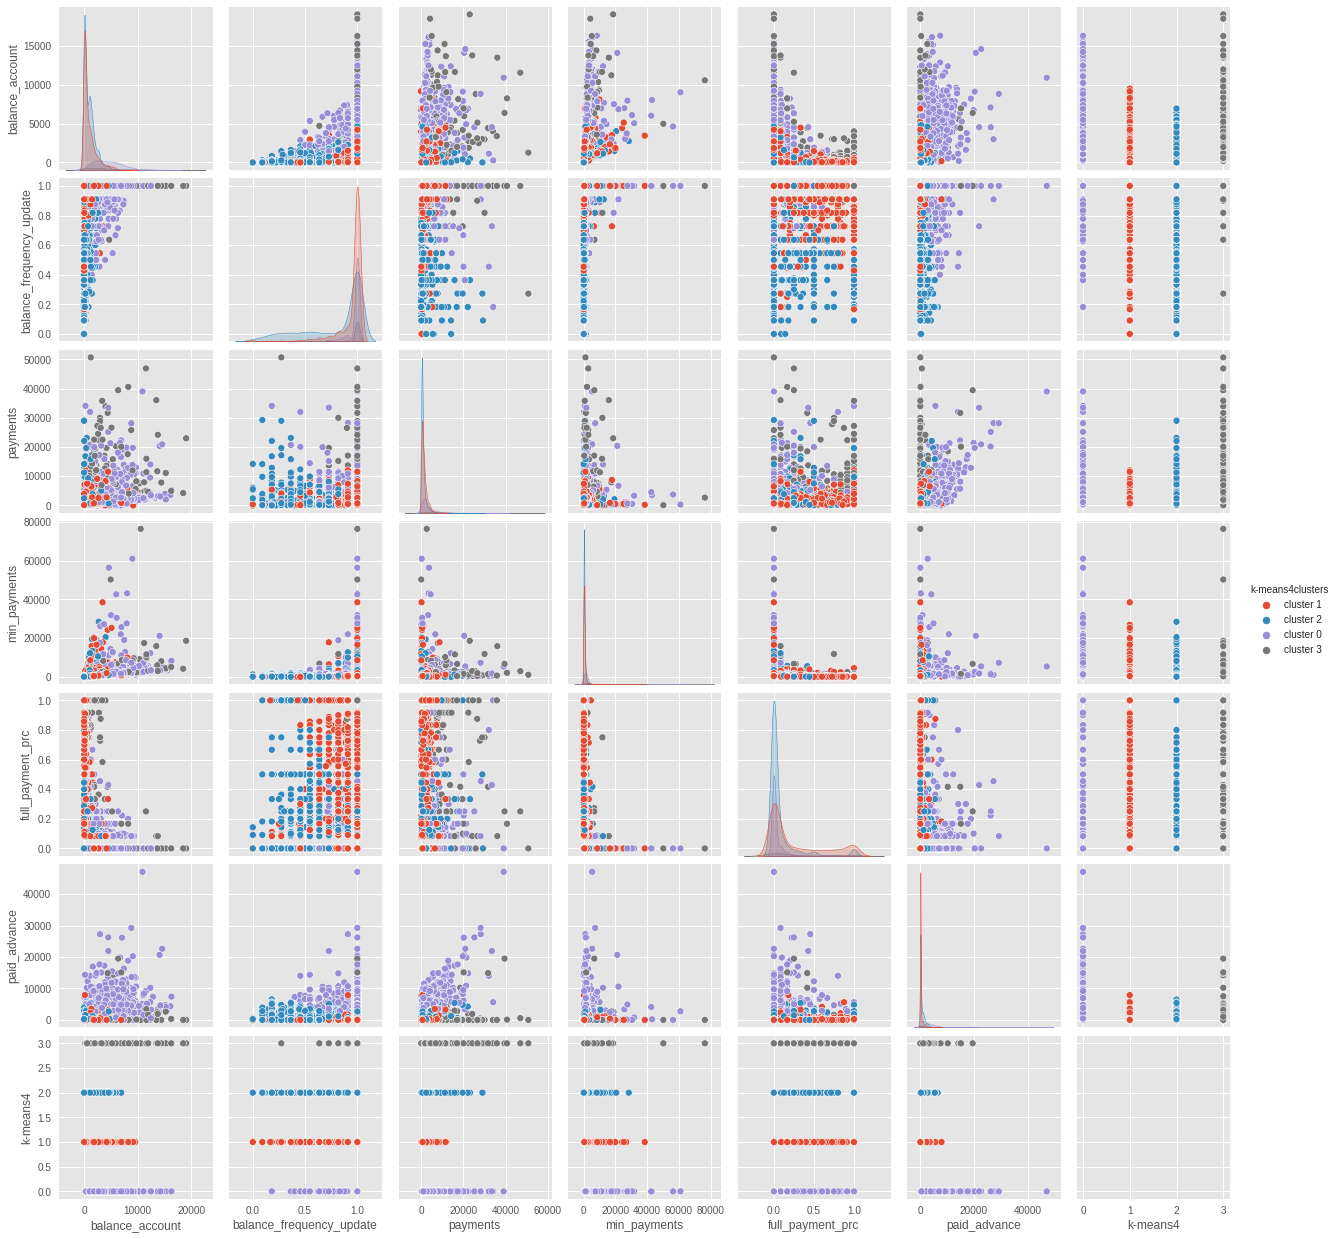

In [ ]:
# set features 2

n_clusters = 4
kmeans_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)),
    ]
)
kmeans_pipeline.fit(data_clean)
labels = kmeans_pipeline.predict(data_clean)
centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_

# cols = ['purchases_amount', 'full_purchases', 'purchases_frequency',
#        'full_purchases_frequency', 'nr_purchases']

cols = ['balance_account', 'balance_frequency_update', 'payments', 'min_payments',
       'full_payment_prc', 'paid_advance']

# cols = ['installments', 'purchases_installments_frequency',
#        'cash_advance_frequency', 'nr_cash_advances',
#        'credit_limit', 'fixed_rate_period']

kmeans_pipeline.fit(data_clean[cols])
data_kmeans = data_clean[cols].copy()
data_kmeans["k-means4"] = labels
data_kmeans["k-means4clusters"] = data_kmeans["k-means4"].map(
    lambda i: "cluster " + str(i)
)

# cols = ['purchases_amount', 'full_purchases', 'purchases_frequency',
#        'full_purchases_frequency', 'nr_purchases', "k-means3clusters"]

cols = ['balance_account', 'balance_frequency_update', 'payments', 'min_payments',
       'full_payment_prc', 'paid_advance', "k-means4clusters"]

# cols = ['installments', 'purchases_installments_frequency',
#        'cash_advance_frequency', 'nr_cash_advances',
#        'credit_limit', 'fixed_rate_period', "k-means3clusters"]

g1 = sns.pairplot(data_kmeans, hue="k-means4clusters")
g1.fig.figsize = (25, 25)

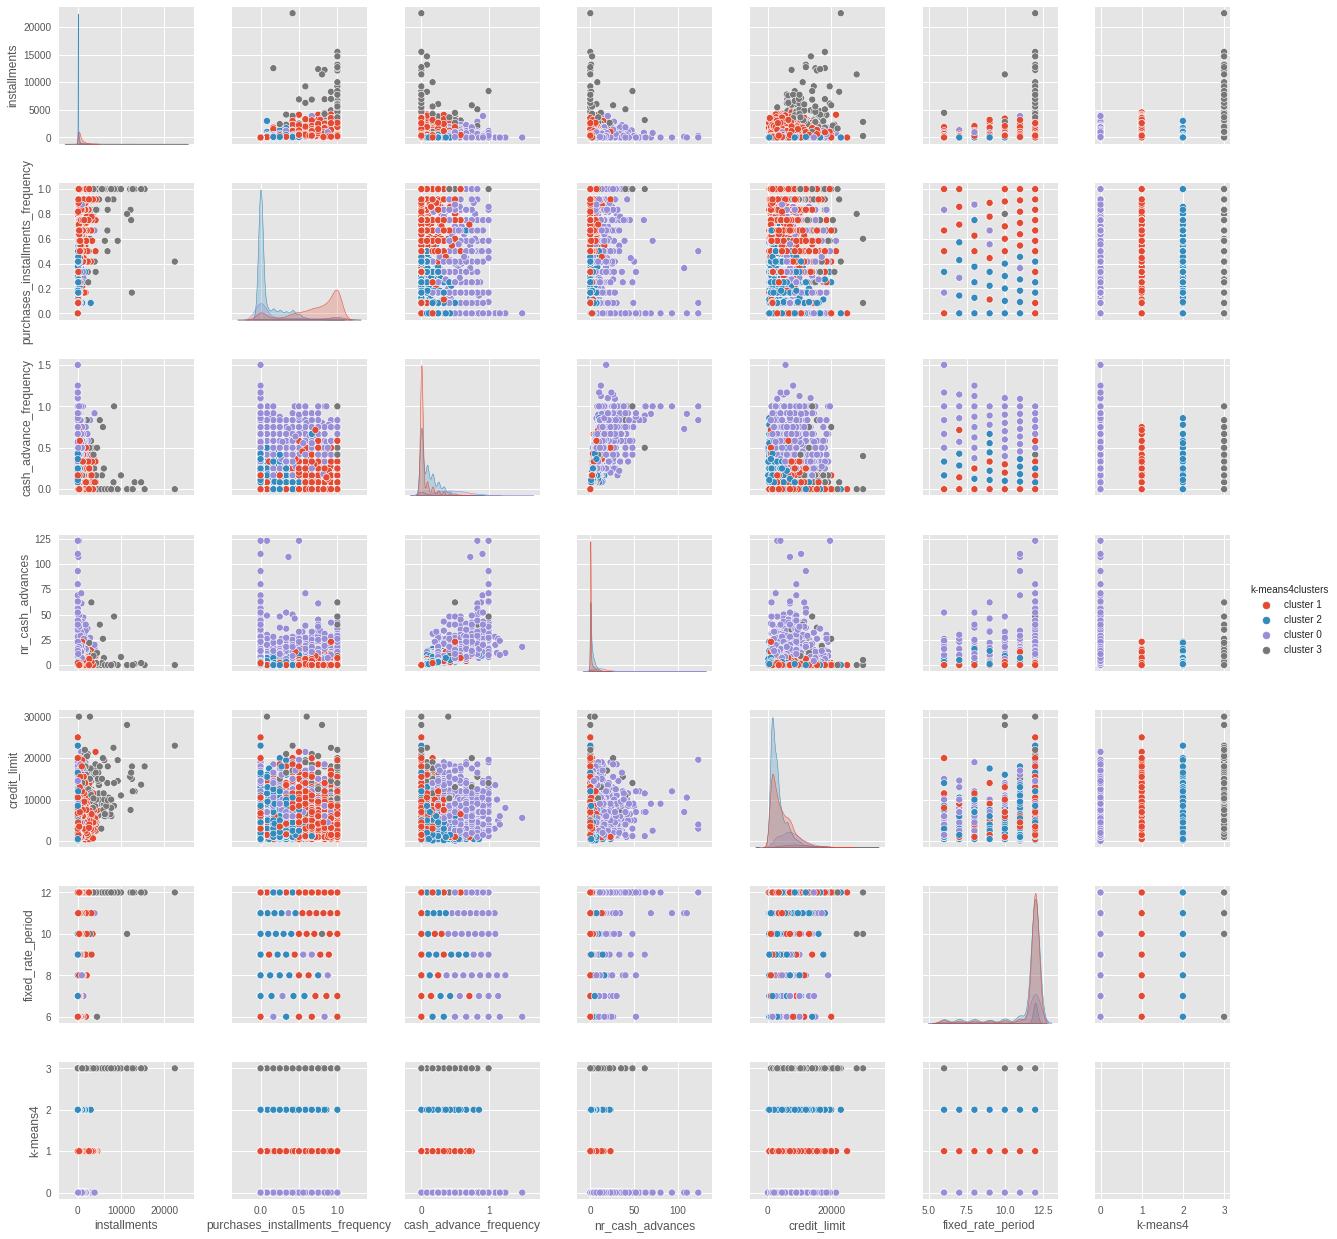

In [ ]:
# set features 3

n_clusters = 4
kmeans_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)),
    ]
)
kmeans_pipeline.fit(data_clean)
labels = kmeans_pipeline.predict(data_clean)
centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_

# cols = ['purchases_amount', 'full_purchases', 'purchases_frequency',
#        'full_purchases_frequency', 'nr_purchases']

# cols = ['balance_account', 'balance_frequency_update', 'payments', 'min_payments',
#        'full_payment_prc', 'paid_advance']

cols = ['installments', 'purchases_installments_frequency',
       'cash_advance_frequency', 'nr_cash_advances',
       'credit_limit', 'fixed_rate_period']

kmeans_pipeline.fit(data_clean[cols])
data_kmeans = data_clean[cols].copy()
data_kmeans["k-means4"] = labels
data_kmeans["k-means4clusters"] = data_kmeans["k-means4"].map(
    lambda i: "cluster " + str(i)
)

# cols = ['purchases_amount', 'full_purchases', 'purchases_frequency',
#        'full_purchases_frequency', 'nr_purchases', "k-means3clusters"]

# cols = ['balance_account', 'balance_frequency_update', 'payments', 'min_payments',
#        'full_payment_prc', 'paid_advance', "k-means3clusters"]

cols = ['installments', 'purchases_installments_frequency',
       'cash_advance_frequency', 'nr_cash_advances',
       'credit_limit', 'fixed_rate_period', "k-means4clusters"]

g1 = sns.pairplot(data_kmeans, hue="k-means4clusters")
g1.fig.figsize = (25, 25)

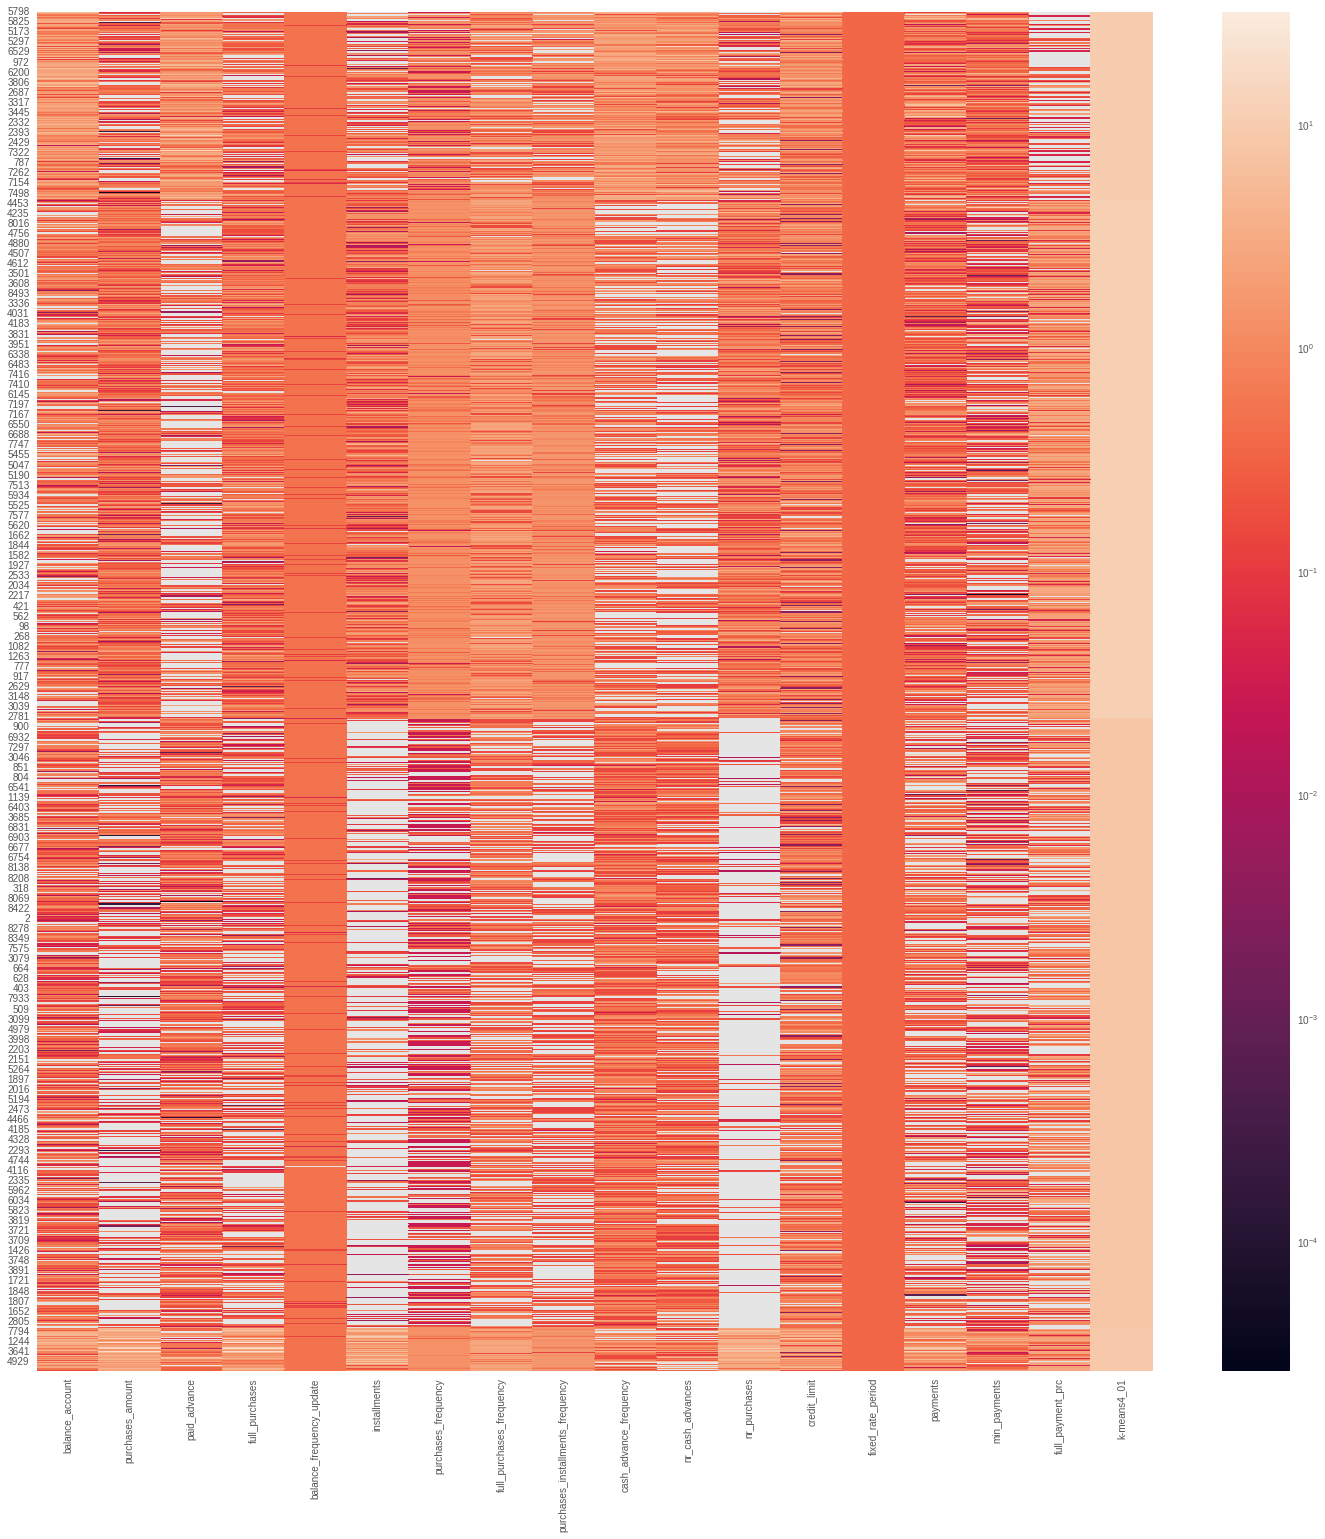

In [ ]:
from matplotlib.colors import LogNorm

df_scaled_ss["customer_id"] = cust_id.astype(str)
# plt.style.use('default')
data_copy = df_scaled_ss.copy()
data_copy["k-means4"] = data_kmeans["k-means4"]
data_copy["k-means4_01"] = 10^(data_kmeans["k-means4"])
plt.figure(figsize=(25,25))
sns.heatmap(data_copy.sort_values(by="k-means4").drop(columns=["customer_id","k-means4"]), 
            norm=LogNorm()
           );

## PCA

In [ ]:
df_pre_pca = df2.copy(deep=True)

In [ ]:
pca = PCA()

In [ ]:
pipe_pca = Pipeline([("pca", pca)])

In [ ]:
pca.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [ ]:
df_pca = pca.fit_transform(df_pre_pca)

In [ ]:
# explained_variance_ratio_ => % variance explained by each of the selected components
# LF max variance

pipe_pca.named_steps["pca"].explained_variance_ratio_

array([2.72866917e-01, 2.03280819e-01, 8.84668626e-02, 7.50110750e-02,
       6.18139850e-02, 5.70656657e-02, 4.87035070e-02, 4.34175788e-02,
       3.79250769e-02, 3.08391074e-02, 2.35473756e-02, 1.77832714e-02,
       1.42690185e-02, 1.21638186e-02, 1.01616015e-02, 2.68361051e-03,
       7.10359216e-07])

In [ ]:
#numpy cumsum returns the cumulative sum of the elements 
#in this case, i

evr = np.cumsum(pipe_pca.named_steps["pca"].explained_variance_ratio_)
evr

array([0.27286692, 0.47614774, 0.5646146 , 0.63962567, 0.70143966,
       0.75850532, 0.80720883, 0.85062641, 0.88855149, 0.91939059,
       0.94293797, 0.96072124, 0.97499026, 0.98715408, 0.99731568,
       0.99999929, 1.        ])

### PCA interceptor location

In [ ]:
# Finding out the interceptor that represents 95% of the total variance:
x_intercept = np.argmax(evr > 0.95) #evr is an array of the cumulative variances
print('The interceptor is located at component: ', x_intercept)

The interceptor is located at component:  11


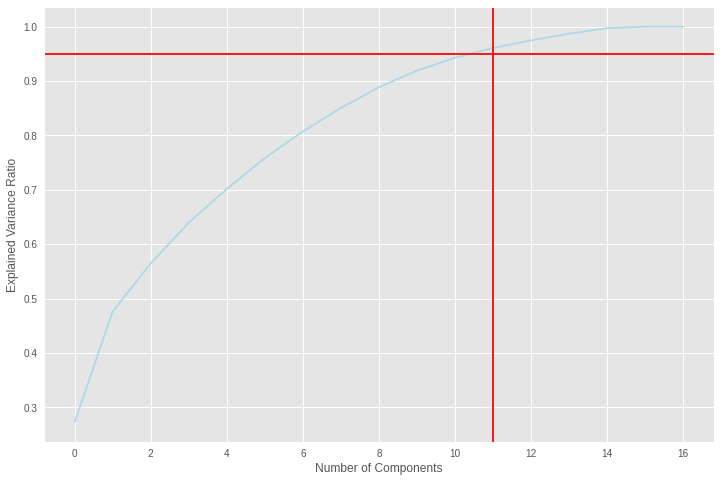

In [ ]:
# Ploting the location of the interceptor:

plt.plot(evr, "-x", color="lightblue") #plotting the cumulative sum of variance, so we can where the variance increases are not as pronounced
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.axvline(x=x_intercept, color="red") #vertical line to see the number of components that corresponds to the 95% total variance
plt.axhline(y=0.95, color="red") #horizontal line for 95% of the total variance 
None

### PCA scatter visualization components

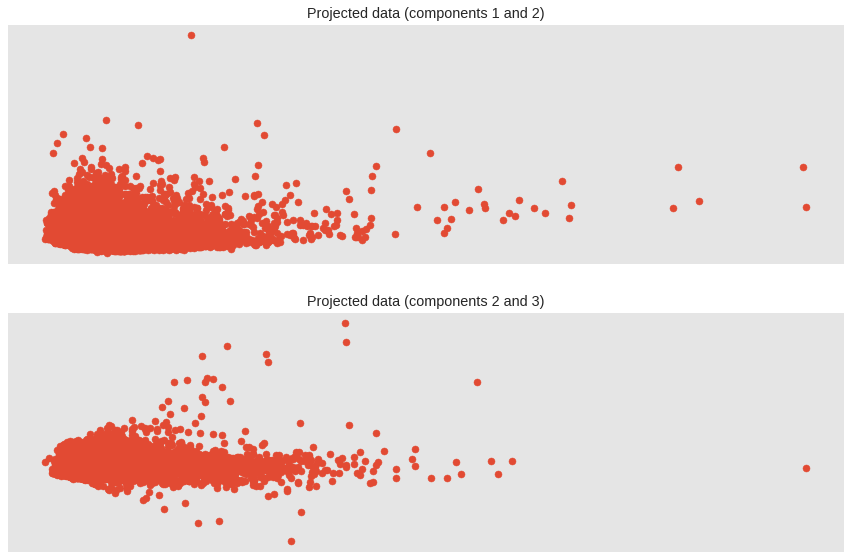

In [ ]:
#After dimensionality reduction, we can use gene_pca plot the principal components 

plt.rcParams["figure.figsize"] = (15, 15)

fig = plt.figure()

# # plot original roll
# ax = fig.add_subplot(311, projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
# ax.set_title("Original data")

# plot projected roll (components 1 and 2)
ax = fig.add_subplot(311)
ax.scatter(df_pca[:, 0], df_pca[:, 1],  cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Projected data (components 1 and 2)')

# plot projected roll (components 2 and 3)
ax = fig.add_subplot(312)
ax.scatter(df_pca[:, 1], df_pca[:, 2],cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Projected data (components 2 and 3)')
plt.show()

plt.show()

## PCA 2

In [ ]:
df_pre_pca_2 = df2.copy(deep=True)

In [ ]:
pca = PCA(n_components = 2)
df_pca_2 = pca.fit_transform(df_pre_pca_2) 
df_pca_2 = pd.DataFrame(df_pca_2) 
df_pca_2.columns = ['P1', 'P2'] 
df_pca_2.head(2)

P1        P2
0 -0.287284 -2.005712
1 -0.687219 -1.702489

### Re-choosing the K

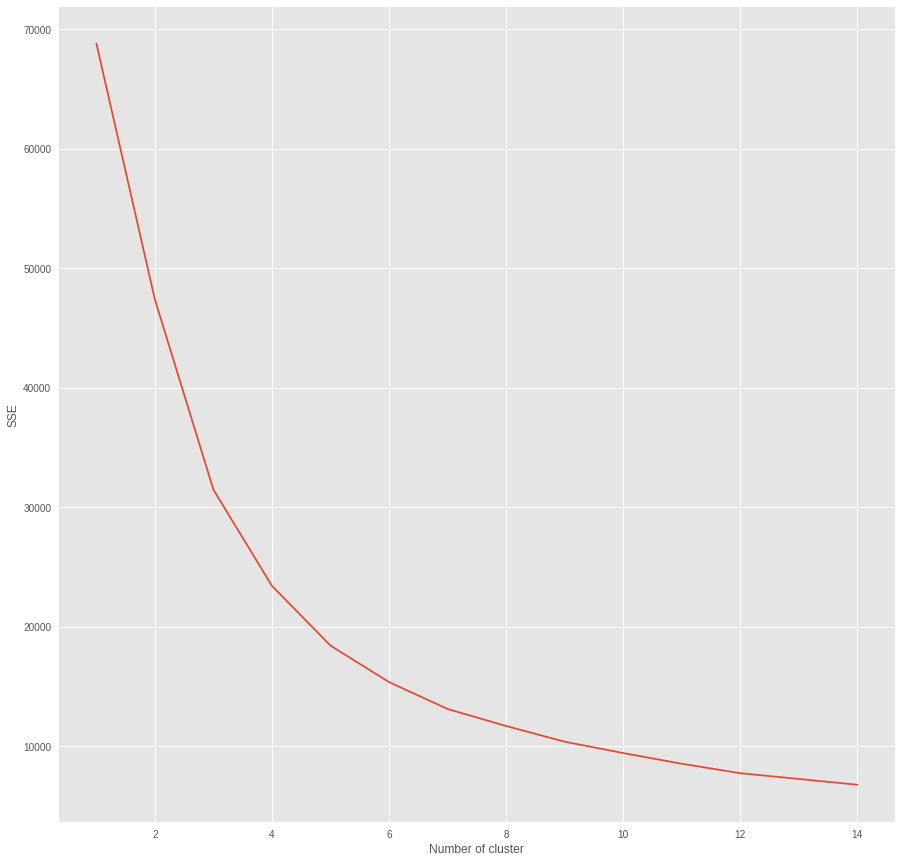

In [ ]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_pca_2)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

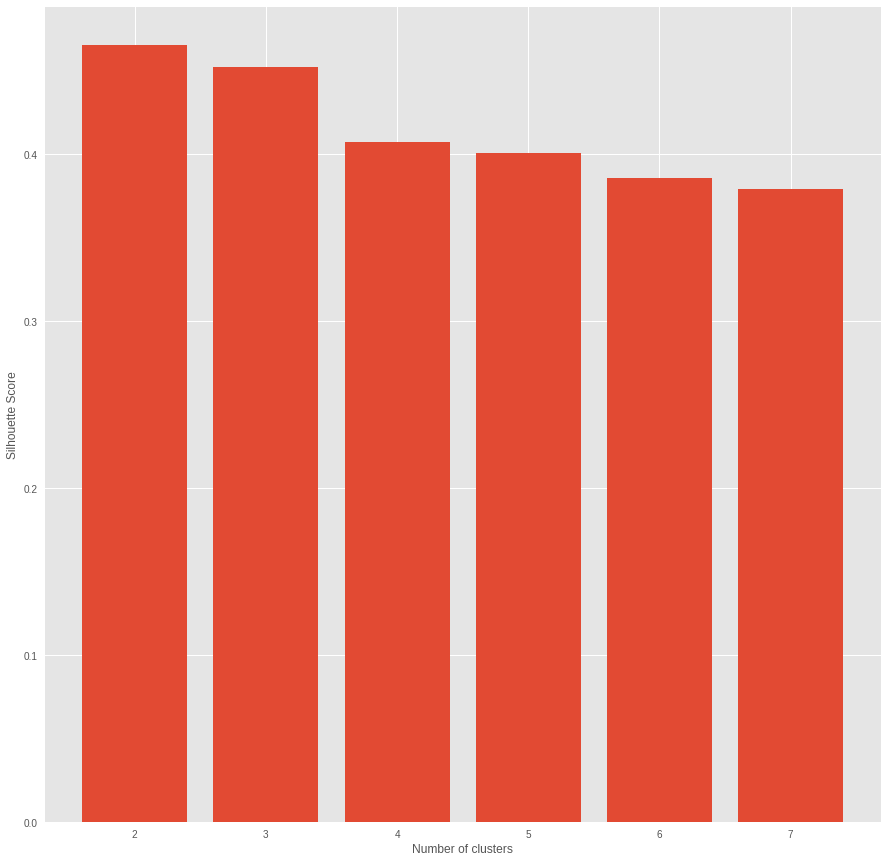

In [ ]:
silhouette_scores = []

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(df_pca_2, KMeans(n_clusters = n_cluster).fit_predict(df_pca_2))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6, 7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters') 
plt.ylabel('Silhouette Score') 
plt.show() 

In [ ]:
# k = 2?
# using k = 3

In [ ]:
kmean= KMeans(3)
kmean.fit(df2)
labels=kmean.labels_

In [ ]:
clusters=pd.concat([df_knn, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

balance_account  purchases_amount  paid_advance  full_purchases  \
0         9.298409            107.60      0.000000            0.00   
1        52.666422            150.30      0.000000            0.00   
2      1360.795674              0.00    462.861443            0.00   
3      2021.641161            363.18      0.000000          363.18   
4        22.322374             95.00   1162.045833           95.00   

   balance_frequency_update  installments  purchases_frequency  \
0                  0.909091         107.6             0.909091   
1                  1.000000         150.3             1.000000   
2                  1.000000           0.0             0.000000   
3                  1.000000           0.0             1.000000   
4                  0.363636           0.0             0.083333   

   full_purchases_frequency  purchases_installments_frequency  \
0                  0.000000                          0.818182   
1                  0.000000                          0.833333   
2                  0.000000                          0.000000   
3                  1.000000                          0.000000   
4                  0.083333                          0.000000   

   cash_advance_frequency  nr_cash_advances  nr_purchases  credit_limit  \
0                0.000000               0.0          10.0        1000.0   
1                0.000000               0.0           6.0        1000.0   
2                0.272727               6.0           0.0        1500.0   
3                0.000000               0.0          13.0        2000.0   
4                0.166667               3.0           1.0        2500.0   

   fixed_rate_period     payments  min_payments  full_payment_prc  cluster  
0               11.0    89.868853     89.711672          0.428571        2  
1                6.0    54.722514     82.955180          0.000000        2  
2               11.0   303.031979    443.781316          0.000000        2  
3               12.0   704.240770    795.859808          0.000000        2  
4               12.0  4094.261427     40.142262          0.000000        2

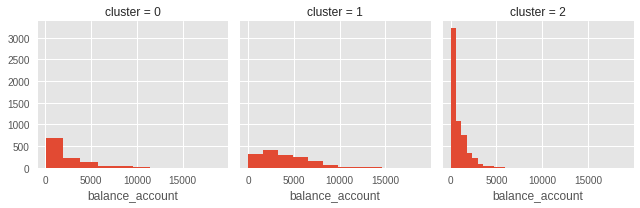

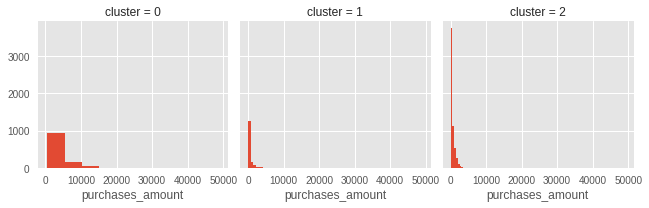

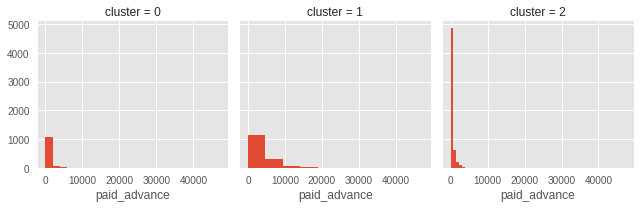

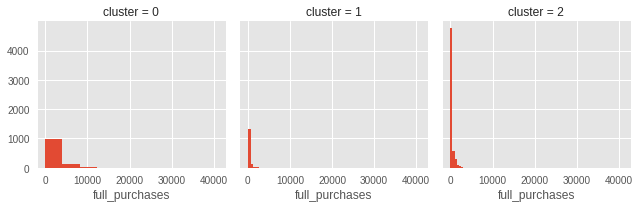

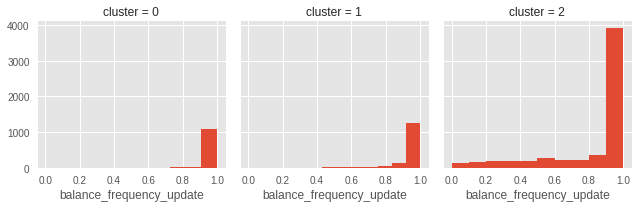

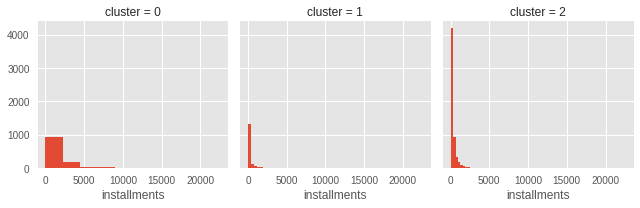

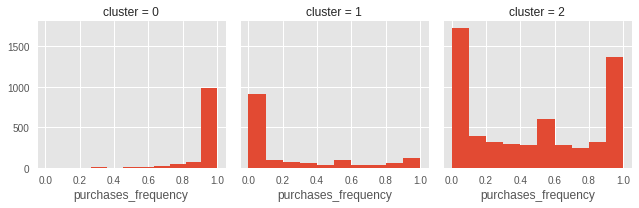

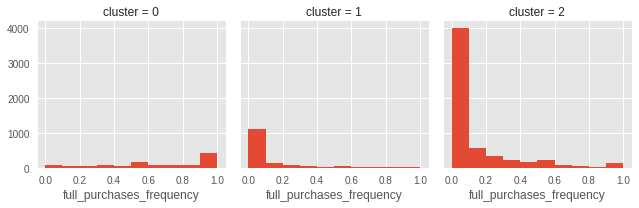

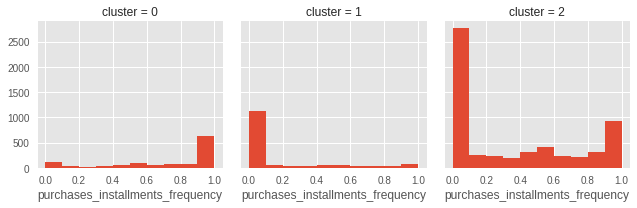

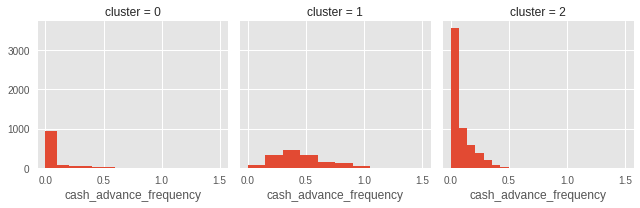

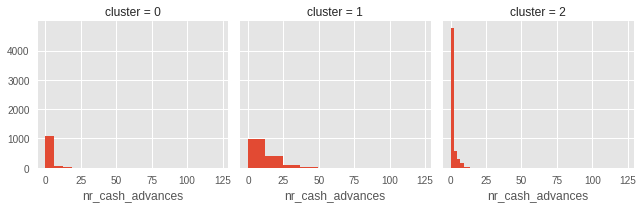

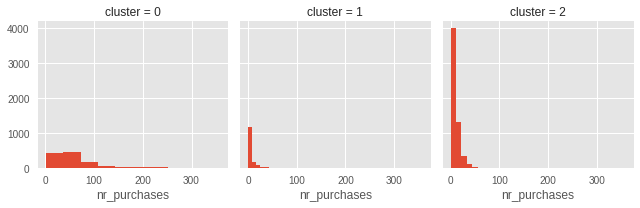

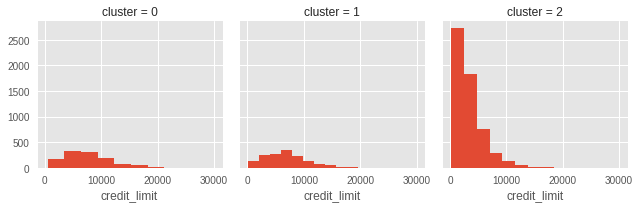

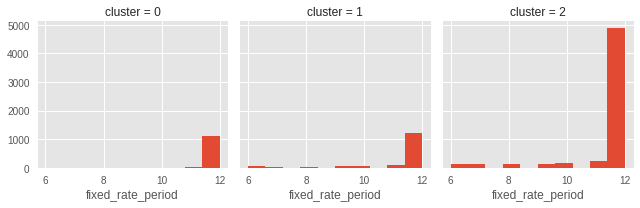

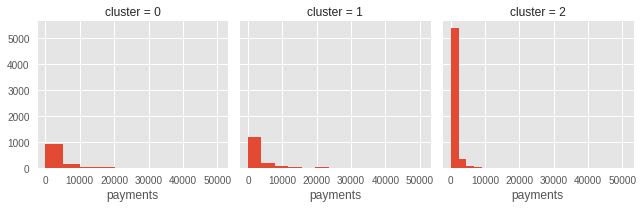

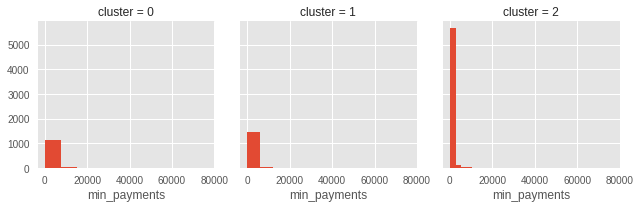

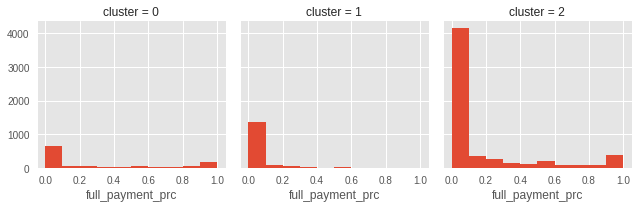

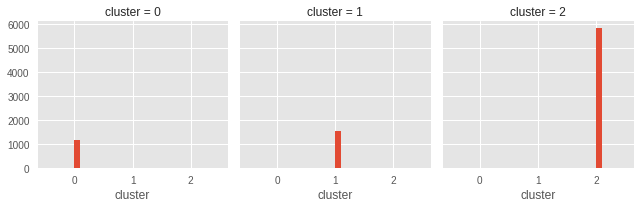

In [ ]:
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

# cluster                0            1         2

# balance                medium       high      low
# balance freq           high         high      high
# purchase               high         low       low
# purchase freq          high         low       spread
# nr. cash advance       low          high      low
# min payment            high         high      low
# credit limit           high         high      low        


In [ ]:
clusters['cluster'].value_counts()

2    5823
1    1517
0    1159
Name: cluster, dtype: int64

In [ ]:
clusters.groupby('cluster').mean()

balance_account  purchases_amount  paid_advance  full_purchases  \
cluster                                                                    
0            2261.203752       4294.143943    471.492924     2720.954676   
1            3989.105118        376.890989   3837.715899      243.099637   
2             796.544035        506.202076    327.384582      253.655672   

         balance_frequency_update  installments  purchases_frequency  \
cluster                                                                
0                        0.981155   1573.706954             0.949242   
1                        0.957546    133.872874             0.231078   
2                        0.834345    252.878357             0.465231   

         full_purchases_frequency  purchases_installments_frequency  \
cluster                                                               
0                        0.668947                          0.747465   
1                        0.110307                          0.143284   
2                        0.132894                          0.344941   

         cash_advance_frequency  nr_cash_advances  nr_purchases  credit_limit  \
cluster                                                                         
0                      0.064414          1.572908     56.953408   7716.954271   
1                      0.448835         12.425840      5.570864   6683.753820   
2                      0.067704          1.199038      8.637300   3270.139719   

         fixed_rate_period     payments  min_payments  full_payment_prc  
cluster                                                                  
0                11.921484  4168.331457   1226.905048          0.295288  
1                11.347396  2970.753540   1833.931893          0.033295  
2                11.480337   908.963608    524.222257          0.155288

In [ ]:
pca = PCA(n_components = 2)
df_pca_2 = pca.fit_transform(df_pre_pca_2) 
df_pca_2 = pd.DataFrame(df_pca_2) 
df_pca_2.columns = ['P1', 'P2'] 
df_pca_2.head(2)

P1        P2
0 -0.287273 -2.005714
1 -0.687227 -1.702494

In [ ]:
df_pca_final = pd.concat([df_pca_2, pd.DataFrame({'cluster':labels})], axis = 1)
df_pca_final.head()

P1        P2  cluster
0 -0.287273 -2.005714        2
1 -0.687227 -1.702494        2
2 -1.970740  0.537520        2
3  0.489088 -0.847710        2
4 -1.642690 -0.015689        2

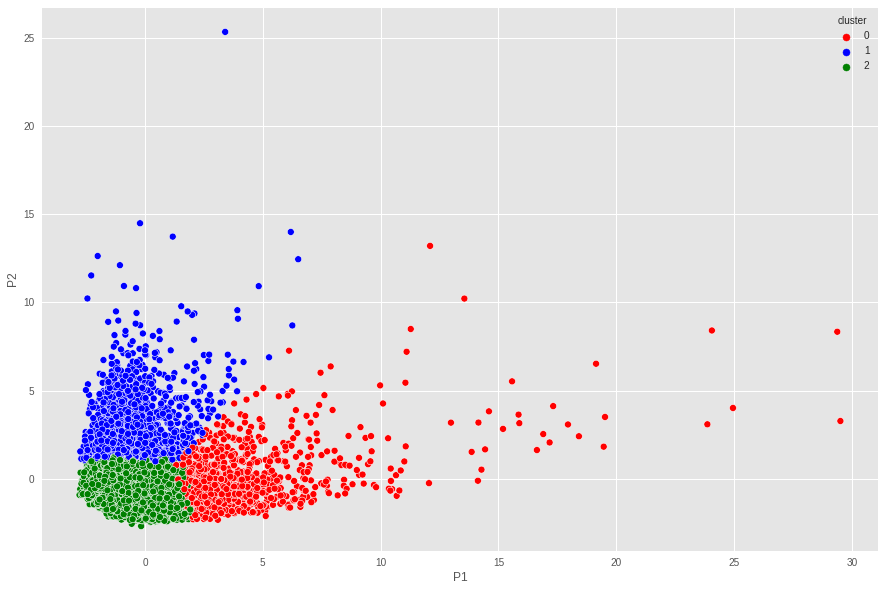

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x="P1", y="P2", hue="cluster", data=df_pca_final,palette=['red','blue','green'])
plt.show()

In [ ]:
# cluster                0            1         2

# balance                medium       high      low
# balance freq           high         high      high
# purchase               high         low       low
# purchase freq          high         low       spread
# nr. cash advance       low          high      low
# min payment            high         high      low
# credit limit           high         high      low 

# C0 medium balance, high purchase, high credit limit
# C1 high balance, high cash advance, low purchase freq, high credit limit, using card as a loan
# C2 low balance, low purchase, low credit limit

## Hierarchical clustering

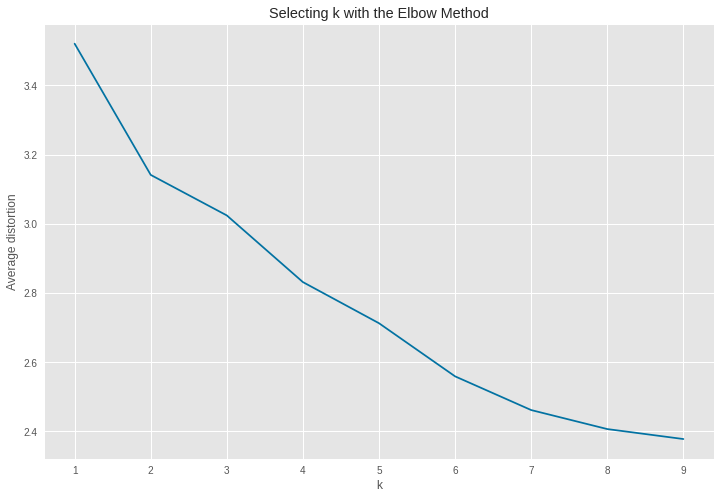

In [ ]:
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
meanDistortions=[]

for k in range(1, 10):
    model=KMeans(n_clusters=k)
    model.fit(df2)
    prediction=model.predict(df2)
    meanDistortions.append(sum(np.min(cdist(df2, model.cluster_centers_, 'euclidean'), axis=1)) / df2.shape[0])


plt.plot(range(1, 10), meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method');

In [ ]:
model = KMeans(n_clusters=3)
model.fit(df2)
preds = model.predict(df2)

In [ ]:
from sklearn.metrics import silhouette_score
labels = model.labels_
silhouette_score(df2, labels, metric='euclidean')

0.2517052882441733

In [ ]:
df2['Kmean_grouping'] = preds #here we add the predictions to the unscaled data so that we can gain some real world interpretability.
df2['Kmean_grouping'] = preds

df2.groupby('Kmean_grouping').count()

balance_account  purchases_amount  paid_advance  \
Kmean_grouping                                                    
0                          1169              1169          1169   
1                          1512              1512          1512   
2                          5818              5818          5818   

                full_purchases  balance_frequency_update  installments  \
Kmean_grouping                                                           
0                         1169                      1169          1169   
1                         1512                      1512          1512   
2                         5818                      5818          5818   

                purchases_frequency  full_purchases_frequency  \
Kmean_grouping                                                  
0                              1169                      1169   
1                              1512                      1512   
2                              5818                      5818   

                purchases_installments_frequency  cash_advance_frequency  \
Kmean_grouping                                                             
0                                           1169                    1169   
1                                           1512                    1512   
2                                           5818                    5818   

                nr_cash_advances  nr_purchases  credit_limit  \
Kmean_grouping                                                 
0                           1169          1169          1169   
1                           1512          1512          1512   
2                           5818          5818          5818   

                fixed_rate_period  payments  min_payments  full_payment_prc  
Kmean_grouping                                                               
0                            1169      1169          1169              1169  
1                            1512      1512          1512              1512  
2                            5818      5818          5818              5818

In [ ]:
df2.drop('Kmean_grouping', inplace=True, axis=1)

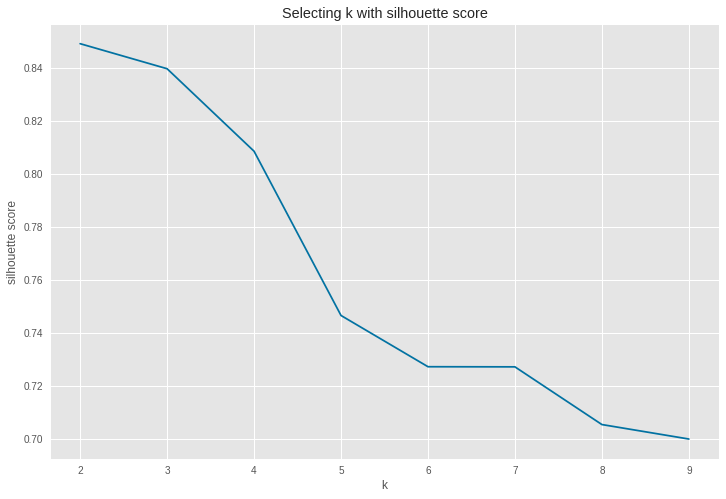

In [ ]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')
model.fit(df2)

meanDistortions=[]

for k in range(2, 10):
    model=AgglomerativeClustering(n_clusters=k, affinity='euclidean',  linkage='average')
    model.fit(df2)
    prediction=model.labels_
    meanDistortions.append(silhouette_score(df2, prediction))


plt.plot(range(2, 10), meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Selecting k with silhouette score');

In [ ]:
Z = linkage(df2[cols], metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(df2[cols]))
plt.figure(figsize=(10, 5))

dendrogram(Z, p=15, truncate_mode='lastp', leaf_rotation=90.,color_threshold = 40, leaf_font_size=8.)
plt.show()

KeyError: ignored